# Load packages

In [45]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
    
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

from scipy import optimize
from scipy.optimize import minimize
from scipy.stats import gumbel_r
from matplotlib.pyplot import cm
import math
import matplotlib
import matplotlib.colors as mcolors
from scipy.optimize import fsolve

import sympy
from sympy import *
from sympy import symbols, Eq, solve
from shapely.geometry import LineString


%matplotlib inline
plt.style.use('ggplot')
import warnings
from scipy.stats import pearsonr
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

output = 'Output24'
Input = 'Input4'

# Catchment descriptors

In [46]:
#HAI
def HAI_calculate(temp, precipitation):

    temp_adjusted = np.zeros(12)
    
    for i in range(1,13):
        if temp[i] < 0:
            temp_adjusted[i-1] = 0
        elif temp[i] > 30:
            temp_adjusted[i-1] = 30
        else:
            temp_adjusted[i-1] = temp[i]            
        
    T = np.sum(temp_adjusted)
    HAI = (58.93 * (T/12))/precipitation
    
    return HAI

#Function for the Seasonality Index
def Seasonality_index(Annual_mean, Monthly_mean):
    SI = (1/Annual_mean) * np.sum(np.abs(Monthly_mean - (Annual_mean/12)))
    
    return SI

#Function for Seasonality Timing Index
def ST_calc(dP,dT):
    days = 366
    ST = dP[0] * np.sign(dT[0]) * np.cos((np.pi * (dP[1] - dT[1]))/days)
    return ST

#Functions to compute Seasonal variability indexes
def T_daily(dT):
    t = np.linspace(1,366,366)
    days = 366
    T = T_mean + dT[0] * np.sin((2*np.pi * (t-dT[1]))/days)
    return T

def Cal_T_daily(dT):
    days = 366
    T_calc = T_daily(dT)
    
    return (np.sum(np.abs(T_calc - T_obs)))/days

def P_daily(dP):
    t = np.linspace(1,366,366)
    days = 366
    P = P_mean * (1 + dP[0] * np.sin((2*np.pi * (t-dP[1]))/days))
    return P

def Cal_P_daily(dP):
    days = 366
    P_calc = P_daily(dP)
    
    return (np.sum(np.abs(P_calc - P_obs)))/days

def E_daily(dE):
#    t = np.linspace(1,366,366)
    t = np.linspace(1,366,366)

    days = 366
    E = E_mean * (1 + dE[0] * np.sin((2*np.pi * (t-dE[1]))/days))
    return E

def Cal_E_daily(dE):
    days = 366
    E_calc = E_daily(dE)
    
    return (np.sum(np.abs(E_calc - E_obs)))/days

#Function for the interstorm duration or low_prec_freq
def Interstorm_duration(P):
    interstorm = []
    count = 0

    for j in range(len(P)):
        if P[j] < 1:
            count += 1
        elif P[j] >= 1 and count > 0:
            interstorm.append(count)
            count = 0 
    interstorm_duration = np.mean(interstorm)
    return interstorm_duration

#Function to compute the root-zone storage capacity
def rootzone(df_out, RP):
    firstyear = df_out['hydroyear'].iloc[0]
    lastyear = df_out['hydroyear'].iloc[-1]
    df_out = df_out.drop(df_out[df_out['hydroyear']==firstyear].index)
    df_out = df_out.drop(df_out[df_out['hydroyear']==lastyear].index)
    years = df_out.groupby(['hydroyear'])
    SD = years['SD_sum'].max() - years['SD_sum'].min()
    var = gumbel_r.fit(SD)
    p = 1-1/RP
    Sr = gumbel_r.ppf(p, var[0],var[1])
    return(Sr, df_out)

#Functions to compute the precipitation variability
def most_common(lst):
    return max(set(lst), key=lst.count)


#compute frequency, duration and timing of high and low precipitation.
def freq_dur_tim_calc(data):
    count_high = 0
    count_low = 0
    mean_daily_P = data['prec_subcatch'].mean()

    colum = np.zeros(len(data))
    data['high_daily_P'] = colum
    list_dur_high = []
    list_tim_high = []
    data['low_daily_P'] = colum
    list_dur_low = []
    list_tim_low = []


    for i in range(1, len(data)):
        if data['prec_subcatch'][i] >= 5*mean_daily_P:
                data['high_daily_P'][i] = 1
                count_high +=1
        if data['high_daily_P'][i] == 0.0 and data['high_daily_P'][i-1] == 1:
                list_dur_high.append(count_high)
                list_tim_high.append(data['dt'].dt.month[i])
                count_high = 0   



        if data['prec_subcatch'][i] <= 1:
                data['low_daily_P'][i] = 1
                count_low += 1

        if data['low_daily_P'][i] == 0.0 and data['low_daily_P'][i-1] == 1:
                list_dur_low.append(count_low)
                list_tim_low.append(data['dt'].dt.month[i])
                count_low = 0


    data_high_P = data['high_daily_P'].resample('A').sum()
    data_low_P = data['low_daily_P'].resample('A').sum()

    high_prec_freq = data_high_P.mean()
    low_prec_freq = data_low_P.mean()
    
    high_prec_dur = np.mean(list_dur_high)
    low_prec_dur  = np.mean(list_dur_low)
    
    month_high = most_common(list_tim_high)
    month_low = most_common(list_tim_low)

    high_prec_tim = month_calc(month_high)
    low_prec_tim  = month_calc(month_low)
    
    
    return high_prec_freq, high_prec_dur, high_prec_tim, low_prec_freq, low_prec_dur, low_prec_tim

def month_calc(month):
    if month == 12 or month == 1 or month == 2:
        return 1
    elif month == 3 or month == 4 or month == 5:
        return 2

    elif month == 6 or month == 7 or month == 8:
        return 3
    elif month == 9 or month == 10 or month == 11:
        return 4
    
def w_function(AI, w):
    EI = 1 + AI - (1 + AI**w)**(1/w)
    return EI

# Load data 

### Data preparation

In [47]:
df_meuse = pd.read_excel("1_Data/Stations_Meuse.xlsx")
meuse_names = df_meuse["Read"]

df_meuse_be = pd.read_excel("1_Data/Stations_Meuse_be.xlsx")
meuse_names_be = df_meuse_be["Read"]

In [48]:
for i in range(len(df_meuse)):
    w_flow = df_meuse.loc[i]["Wflow_ID"]
    series = pd.read_csv("1_Data/final/"+str(w_flow)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    series.to_csv("1_Data/final_names/"+str(df_meuse.loc[i]["Read"].strip())+str(".csv"))

#### Dictorionairies

In [49]:
fr_dict = dict([
    ("La Meuse à Goncourt", "La Meuse Goncourt"),
    ("Le Mouzon à Circourt-sur-Mouzon [Villars]", "Le Mouzon Circourt-sur-Mouzon [Villars]"),
    ("Le Vair à Soulosse-sous-Saint-Élophe", "Le Vair Soulosse-sous-Saint-Élophe"),
    ("La Meuse à Saint-Mihiel", "La Meuse Saint-Mihiel"),
    ("La Meuse à Stenay", "La Meuse Stenay"),
    ("La Chiers à Longlaville", "La Chiers Longlaville"),
    ("La Crusnes à Pierrepont", "La Crusnes Pierrepont"),
    ("Le Ton à Écouviez", "Le Ton Écouviez"),
    ("Le Loison à Han-lès-Juvigny", "Le Loison Han-lés-Juvigny"),
    ("La Chiers à Carignan", "La Chiers Carignan"),
    ("La Bar à Cheveuges", "La Bar Cheveuges"),
    ("La Vence à la Francheville", "La Vence la Francheville"),
    ("La Sormonne à Belval", "La Sormonne Belval"),
    ("La Meuse à Chooz", "Chooz"),
])

fr_dict_inv = dict([
    ("La Meuse Goncourt", "La Meuse à Goncourt"),
    ("Le Mouzon Circourt-sur-Mouzon [Villars]", "Le Mouzon à Circourt-sur-Mouzon [Villars]",),
    ("Le Vair Soulosse-sous-Saint-Élophe", "Le Vair à Soulosse-sous-Saint-Élophe"),
    ("La Meuse Saint-Mihiel", "La Meuse à Saint-Mihiel"),
    ("La Meuse Stenay", "La Meuse à Stenay"),
    ("La Chiers Longlaville", "La Chiers à Longlaville"),
    ("La Crusnes Pierrepont", "La Crusnes à Pierrepont"),    
    ("Le Ton Écouviez", "Le Ton à Écouviez"),
    ("Le Loison Han-lés-Juvigny", "Le Loison à Han-lès-Juvigny"),
    ("La Chiers Carignan", "La Chiers à Carignan"),
    ("La Bar Cheveuges", "La Bar à Cheveuges"),
    ("La Vence la Francheville", "La Vence à la Francheville"),
    ("La Sormonne Belval", "La Sormonne à Belval"),
    ("Chooz", "La Meuse à Chooz"),
])

fr_dict_code = dict([
    ("B0220010", "La Meuse Goncourt"),
    ("B1092010", "Le Mouzon Circourt-sur-Mouzon [Villars]"),
    ("B1282010", "Le Vair Soulosse-sous-Saint-Élophe"),
    ("B2220010", "La Meuse Saint-Mihiel"),
    ("B3150020", "La Meuse Stenay"),
    ("B4001010", "La Chiers Longlaville"),
    ("B4132010", "La Crusnes Pierrepont"),
    ("B4224310", "Le Ton Écouviez"),
    ("B4572010", "Le Loison Han-lés-Juvigny"),
    ("B4631010", "La Chiers Carignan"),
    ("B5172010", "La Bar Cheveuges"),
    ("B5322010", "La Vence la Francheville"),
    ("B5572010", "La Sormonne Belval"),
    ("B7200000", "Chooz"),
])

#### Determine area sizes

In [50]:
df_area = pd.read_csv("1_Data/Stations_area.csv", delimiter=',',skipinitialspace=True)
df_area.index = df_area['Station']
df_area["area_m2"] = df_area["area_km2"] * 10**6

### Prepare data (FR)

In [85]:
df_fr_new = pd.read_csv("1_Data\export_hydro_series.csv", sep = ";", decimal = ",", skiprows=[0] , na_values=['-999.0', 'n.a.'], parse_dates=True)
st = np.unique(df_fr_new["Code du site hydrométrique"])
meuse_names_fr = []
stations = []

for i in range(len(st)):
    code = st[i]
    if fr_dict_code[code] != 'La Crusnes Pierrepont' and fr_dict_code[code] != 'Le Ton Écouviez' and fr_dict_code[code] != 'La Sormonne Belval' and fr_dict_code[code] != 'La Chiers Longlaville' and fr_dict_code[code] != 'La Bar Cheveuges':
        meuse_names_fr.append(fr_dict_code[code])
        stations.append(st[i])
        
        
yrcut_fr = [1980, 1990, 2000, 2010, 2020]
yrsl = []
yrcut = yrcut_fr 
for i in range(len(yrcut)-1):
    sl = f'{yrcut[i]} - {yrcut[i+1]-1}'
    yrsl.append(sl)
    
yrsl_fr = yrsl

print(yrsl_fr)

['1980 - 1989', '1990 - 1999', '2000 - 2009', '2010 - 2019']


### Prepare data (BE)

In [86]:
yrcut_be = [1996, 2006, 2016]  # het laatste jaar zit er niet in
colors = ['#9FB2FF', '#496AFF', '#0020AF', '#001678']
colors2 = ['#6CC24A','#FFB81C', '#A50034']

yrsl = []
yrcut = yrcut_be
for i in range(len(yrcut)-1):
    sl = f'{yrcut[i]} - {yrcut[i+1]-1}'
    yrsl.append(sl)
    
yrsl_be = yrsl

print(yrsl_be)

meuse_names_be2 = []
for i in range(len(meuse_names_be)):
    if meuse_names_be[i] != 'Chaudfontaine Pisc ' and meuse_names_be[i] != 'Sainte-Marie' and meuse_names_be[i] != 'Straimont ' and meuse_names_be[i] != 'Daverdisse ' and meuse_names_be[i] != 'Gendron ' and meuse_names_be[i] != 'Yvoir ' and meuse_names_be[i] != 'Modave ' and meuse_names_be[i] != 'Ortho ' and meuse_names_be[i] != 'Mabompre ' and meuse_names_be[i] != 'Tabreux ' and meuse_names_be[i] != 'Martinrive ' and meuse_names_be[i] != 'Salzinnes ':
        meuse_names_be2.append(meuse_names_be[i])
        


['1996 - 2005', '2006 - 2015']


## AI en ST total (FR)

In [87]:
catchment_list = meuse_names_fr
warnings.filterwarnings('ignore')
yrsl = yrsl_fr

AI_total = []
ST_total = []

for i in range(len(catchment_list)):
    name = fr_dict_code[stations[i]]
    df_station = df_fr_new[df_fr_new["Code du site hydrométrique"] == stations[i]]
    df_station.loc[:,'dt'] = pd.to_datetime(df_station["Date d'observation élaborée hydrométrique"])
    df_station.index = df_station['dt']
    df_station["Q"] = df_station["Résultat de l'observation élaborée hydrométrique"].astype('float32') / 1000 #  l/s naar m3/s
    dataq_fr = df_station[['Code de la station hydrométrique', 'dt', 'Q']].copy()
    dataq_fr = dataq_fr.dropna(axis='rows')
    
    data = pd.read_csv("1_Data/final_names/"+str(name.strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    namefr = fr_dict_inv[name]  
    are = df_area[df_area['Station']== namefr]
    area = are['area_m2'].item()
    
    dataq_fr["hour"] = dataq_fr["Q"] * 3600 * 24
    dataq_fr_day = dataq_fr.resample('D').sum() 
    dataq_fr_day["day"] = dataq_fr_day["hour"]
    dataq_fr_day["Q_mm"] = dataq_fr_day["day"]   * 10**3
    dataq_fr_day["Q_mm_area"] = dataq_fr_day["Q_mm"] / area
    
#    Get the right dates (1996 - 2016)
    data = data.loc["1980-01-01":"2016-12-31"]
    data['dis_subcatch'] = dataq_fr_day.loc["1980-01-01":"2016-12-31","Q_mm_area"]
    # display(data)

       
#     # Calculate mean values
    Ep = data['epot_subcatch'].mean() 
    P = data['prec_subcatch'].mean() 
    Q = data['dis_subcatch'].mean()
    T = data['temp_subcatch'].mean()
    
#     #Compute actual evaporation, Evaporative Index and Aridity index
    Ea = P - Q 
    EI = Ea / P
    AI = Ep / P
    
    #Compute the seasonality variability indexes
    data_d = data.resample('d').mean().bfill()
    daily_sliced_mean = data.groupby([data_d.index.month, data_d.index.day]).agg(np.mean)
    
    T1 = np.zeros((366))
    P1 = np.zeros((366))
    E1 = np.zeros((366))
    count = 0

    
    for k in range(1,13):
        for m in range(1,len(daily_sliced_mean['temp_subcatch'][k])+1):
            T1[count] = daily_sliced_mean['temp_subcatch'][k,m]
            P1[count] = daily_sliced_mean['prec_subcatch'][k,m]
            E1[count] = daily_sliced_mean['epot_subcatch'][k,m]
            count += 1
    t = np.linspace(1,366,366)
    
    T_obs = T1
    P_obs = P1
    E_obs = E1

    T_mean = np.nanmean(T_obs)
    P_mean = np.nanmean(P_obs)
    E_mean = np.nanmean(E_obs)

    x0_T = [5, 110]
    x0_P = [0.3, 40]
    x0_E = [0.4, 40]
    lb = [0, np.inf]
    ub = [0, 366]
    
    res_T = minimize(Cal_T_daily, x0_T,method='Powell', bounds=(lb,ub))
    res_P = minimize(Cal_P_daily, x0_P, method='Powell', bounds=(lb,ub))
    res_E = minimize(Cal_E_daily, x0_E, method='Powell', bounds=(lb,ub))

    dp = res_P.x[0]
    sp = res_P.x[1] / 366
    dt = res_T.x[0]
    st = res_T.x[1] / 366
        
    if abs(sp - st) <= 0.5:
        sd = sp - st

    elif (sp - st) > 0.5:
        sd = -1 + (sp - st)

    else:
        sd = 1 + (sp - st)

    de = res_E.x[0]
    se = res_E.x[1] / 366

    # Compute variables
    ST = ST_calc(res_P.x,res_T.x)
    
    AI_total.append(AI)
    ST_total.append(ST)

## AI & ST total (BE)

In [88]:
"AI total (BE)"
catchment_list = meuse_names_be2
yrsl = yrsl_be


for i in range(len(catchment_list)):
    # Import data and select right dates
    data = pd.read_csv("1_Data/final_names/"+str(catchment_list[i].strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    name = catchment_list[i].strip()
    nameupper = name.upper()
       
    # Read Belgian data        
    dataq = pd.read_csv("1_Data/SPW_names/"+str("SPW_Q_")+str(nameupper)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    dataq.columns = ['dt', 'Q']
    dataq.loc[:,'dt'] = pd.to_datetime(dataq['dt'])
    dataq.index = dataq['dt']
        
    are = df_area[df_area['Station']== name]
    area = are['area_m2'].item()

    dataq["hour"] = dataq["Q"] * 3600
    dataq_day = dataq.resample('D').sum() 
    dataq_day["day"] = dataq_day["hour"]
    dataq_day["Q_mm"] = dataq_day["day"] * 10**3   
    dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
    
    
    # get the right dates (1996 - 2016)
    data = data.loc["1996-01-01":"2016-12-31"]
    data['dis_subcatch'] = dataq_day.loc["1996-01-01":"2016-12-31","Q_mm_area"]
            
    # Calculate mean values
    Ep = data['epot_subcatch'].mean() 
    P = data['prec_subcatch'].mean() 
    Q = data['dis_subcatch'].mean()
    
    #Compute actual evaporation, Evaporative Index and Aridity index
    Ea = P - Q 
    EI = Ea / P
    AI = Ep / P
    
    #Compute the seasonality variability indexes
    data_d = data.resample('d').mean().bfill()
    daily_sliced_mean = data.groupby([data_d.index.month, data_d.index.day]).agg(np.mean)
    
    T1 = np.zeros((366))
    P1 = np.zeros((366))
    E1 = np.zeros((366))
    count = 0

    
    for k in range(1,13):
        for m in range(1,len(daily_sliced_mean['temp_subcatch'][k])+1):
            T1[count] = daily_sliced_mean['temp_subcatch'][k,m]
            P1[count] = daily_sliced_mean['prec_subcatch'][k,m]
            E1[count] = daily_sliced_mean['epot_subcatch'][k,m]
            count += 1
    t = np.linspace(1,366,366)
    
    T_obs = T1
    P_obs = P1
    E_obs = E1

    T_mean = np.nanmean(T_obs)
    P_mean = np.nanmean(P_obs)
    E_mean = np.nanmean(E_obs)

    x0_T = [5, 110]
    x0_P = [0.3, 40]
    x0_E = [0.4, 40]
    lb = [0, np.inf]
    ub = [0, 366]
    
    res_T = minimize(Cal_T_daily, x0_T,method='Powell', bounds=(lb,ub))
    res_P = minimize(Cal_P_daily, x0_P, method='Powell', bounds=(lb,ub))
    res_E = minimize(Cal_E_daily, x0_E, method='Powell', bounds=(lb,ub))

    dp = res_P.x[0]
    sp = res_P.x[1] / 366
    dt = res_T.x[0]
    st = res_T.x[1] / 366
        
    if abs(sp - st) <= 0.5:
        sd = sp - st

    elif (sp - st) > 0.5:
        sd = -1 + (sp - st)

    else:
        sd = 1 + (sp - st)

    de = res_E.x[0]
    se = res_E.x[1] / 366

    # Compute variables
    ST = ST_calc(res_P.x,res_T.x)
    
    AI_total.append(AI)
    ST_total.append(ST)

## Calculate AI & ST cuts

In [108]:
ngroup_AI = round(len(AI_total)/3)
AI_total.sort()
cut1_AI = AI_total[ngroup_AI-1]
cut2_AI = AI_total[2*ngroup_AI-1]
min_AI = min(AI_total)
max_AI = max(AI_total)

ngroup_ST = round(len(ST_total)/3)
print(ngroup_ST)
ST_total.sort()
cut1_ST = ST_total[ngroup_ST-1]
cut2_ST = ST_total[2*ngroup_ST-1]
max_ST = max(ST_total)
min_ST = min(ST_total)

print(ST_total)
print(len(ST_total))
print(cut1_ST)
print(cut2_ST)

6
[0.020678989725065513, 0.0267910797253115, 0.030927851523258096, 0.03419768541471715, 0.03576696925401694, 0.03588290133970738, 0.03854450911517192, 0.04166058066207048, 0.04208268069887071, 0.04261345918758612, 0.04474420839568833, 0.048127000657179245, 0.04911655903765188, 0.05013470290703279, 0.06641342451779626, 0.06670617673553288, 0.07157418235768251]
17
0.03588290133970738
0.048127000657179245


## Loop (FR)

In [90]:
"Loop FR"
catchment_list = meuse_names_fr
warnings.filterwarnings('ignore')
df_output = pd.DataFrame(index=catchment_list)
yrsl = yrsl_fr
yrcut = yrcut_fr

catchment_list_fr_arid = []
catchment_list_fr_med = []
catchment_list_fr_wet = []

catchment_list_fr_STlow = []
catchment_list_fr_STmed = []
catchment_list_fr_SThigh = []


for i in range(len(catchment_list)):
    name = fr_dict_code[stations[i]]
    df_station = df_fr_new[df_fr_new["Code du site hydrométrique"] == stations[i]]
    df_station.loc[:,'dt'] = pd.to_datetime(df_station["Date d'observation élaborée hydrométrique"])
    df_station.index = df_station['dt']
    df_station["Q"] = df_station["Résultat de l'observation élaborée hydrométrique"].astype('float32') / 1000 #  l/s naar m3/s
    dataq_fr = df_station[['Code de la station hydrométrique', 'dt', 'Q']].copy()
    dataq_fr = dataq_fr.dropna(axis='rows')
    
    data = pd.read_csv("1_Data/final_names/"+str(name.strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    namefr = fr_dict_inv[name]  
    are = df_area[df_area['Station']== namefr]
    area = are['area_m2'].item()
    
    dataq_fr["hour"] = dataq_fr["Q"] * 3600 * 24
    dataq_fr_day = dataq_fr.resample('D').sum() 
    dataq_fr_day["day"] = dataq_fr_day["hour"]
    dataq_fr_day["Q_mm"] = dataq_fr_day["day"]   * 10**3
    dataq_fr_day["Q_mm_area"] = dataq_fr_day["Q_mm"] / area
    
#    Get the right dates (1996 - 2016)
    data = data.loc["1980-01-01":"2016-12-31"]
    data['dis_subcatch'] = dataq_fr_day.loc["1980-01-01":"2016-12-31","Q_mm_area"]
    # display(data)

       
#     # Calculate mean values
    Ep = data['epot_subcatch'].mean() 
    P = data['prec_subcatch'].mean() 
    Q = data['dis_subcatch'].mean()
    T = data['temp_subcatch'].mean()
    
#     #Compute actual evaporation, Evaporative Index and Aridity index
    Ea = P - Q 
    EI = Ea / P
    AI = Ep / P
    
        #Compute the seasonality variability indexes
    data_d = data.resample('d').mean().bfill()
    daily_sliced_mean = data.groupby([data_d.index.month, data_d.index.day]).agg(np.mean)
    
    T1 = np.zeros((366))
    P1 = np.zeros((366))
    E1 = np.zeros((366))
    count = 0

    
    for k in range(1,13):
        for m in range(1,len(daily_sliced_mean['temp_subcatch'][k])+1):
            T1[count] = daily_sliced_mean['temp_subcatch'][k,m]
            P1[count] = daily_sliced_mean['prec_subcatch'][k,m]
            E1[count] = daily_sliced_mean['epot_subcatch'][k,m]
            count += 1
    t = np.linspace(1,366,366)
    
    T_obs = T1
    P_obs = P1
    E_obs = E1

    T_mean = np.nanmean(T_obs)
    P_mean = np.nanmean(P_obs)
    E_mean = np.nanmean(E_obs)

    x0_T = [5, 110]
    x0_P = [0.3, 40]
    x0_E = [0.4, 40]
    lb = [0, np.inf]
    ub = [0, 366]
    
    res_T = minimize(Cal_T_daily, x0_T,method='Powell', bounds=(lb,ub))
    res_P = minimize(Cal_P_daily, x0_P, method='Powell', bounds=(lb,ub))
    res_E = minimize(Cal_E_daily, x0_E, method='Powell', bounds=(lb,ub))

    dp = res_P.x[0]
    sp = res_P.x[1] / 366
    dt = res_T.x[0]
    st = res_T.x[1] / 366
        
    if abs(sp - st) <= 0.5:
        sd = sp - st

    elif (sp - st) > 0.5:
        sd = -1 + (sp - st)

    else:
        sd = 1 + (sp - st)

    de = res_E.x[0]
    se = res_E.x[1] / 366

    # Compute variables
    ST = ST_calc(res_P.x,res_T.x)
    
    
    # Calculate root zone storage deficits
    RP    = 20 # Return-period of 20 years
    P_ts  = data['prec_subcatch']
    EP_ts = data['epot_subcatch']

    Et = np.zeros(len(P_ts))
    SD = np.zeros(len(P_ts))

    for z in range(len(P_ts)):
        Et[z] = (EP_ts[z]/Ep) * Ea
        if z == 0:
            SD[z] = min(0, P_ts[z] - Et[z])
        else:
            SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
    data.loc[:,'SD'] = SD
            
    data['year'] = pd.DatetimeIndex(data['dt']).year
    df_out = pd.DataFrame(index = data.index)
    df_out['hydroyear'] = data['year']
    df_out['SD_sum'] = data['SD']
    Sr = rootzone(df_out,RP)[0]    
        
    if AI <= cut1_AI:
        catchment_list_fr_wet.append(catchment_list[i])
    elif cut1_AI <= AI <= cut2_AI:
        catchment_list_fr_med.append(catchment_list[i])
    elif cut2_AI < AI:
        catchment_list_fr_arid.append(catchment_list[i])
        
        
    if ST <= cut1_ST:
        catchment_list_fr_STlow.append(catchment_list[i])
    elif cut1_ST <= ST <= cut2_ST:
        catchment_list_fr_STmed.append(catchment_list[i])
    elif cut2_ST < ST:
        catchment_list_fr_SThigh.append(catchment_list[i])

    
    budyko_curve_x = np.arange(1, 3, 0.05)
    energy_limit_x = np.arange(0, 1.0001, 0.05)
    x = np.arange(0, 1.0001, 0.05)
    water_limit_y = 1 + budyko_curve_x*0
    energy_limit_y = energy_limit_x
    y = 1 + x*0
        
    fig, axs = plt.subplots(2, 1)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.suptitle(f'FR {name}', fontsize = 20)

    axs[0].plot(energy_limit_x, energy_limit_y, c='k')
    axs[0].plot(budyko_curve_x, water_limit_y,c='k')

    axs[0].set_ylabel("Actual ET/P")
    axs[0].set_xlabel("Potential ET/P")
    axs[0].minorticks_on()
                             
    # plot annual deficits
    axs[1].set_ylabel(f'Root zone storage deficit [mm]')
    
    df_output.loc[catchment_list[i],[f'AI']] = AI
    df_output.loc[catchment_list[i],[f'EI']] = EI
    df_output.loc[catchment_list[i],[f'Sr']] = Sr
    
    # Seperate data into slices
    data['year'] = pd.DatetimeIndex(data['dt']).year
    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
        c = colors[j]
        yearslice = yrsl[j]    
                    
        #Compute the Makkink potential evaporation
        Ep = datanew['epot_subcatch'].mean()    
        T = datanew['temp_subcatch'].mean()
        P  = datanew['prec_subcatch'].mean()
        Q  = datanew['dis_subcatch'].mean()

        #Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  # actual evaporation
        AI = Ep / P   # aridity index
        EI = Ea / P # evaporative index
        
        if AI < EI:
            print(f'Exclude catchment with ID (2) {catchment_list[i]}')
                    
        EI_line = np.linspace(EI, EI, 1000000)
        w_array = np.linspace(0, 5000, 1000000)
        Eq_tosolve = 1 + AI - (1 + (AI**w_array))**(1/w_array)

        first_line = LineString(np.column_stack((w_array, EI_line)))
        second_line = LineString(np.column_stack((w_array, Eq_tosolve)))
        intersection = first_line.intersection(second_line)

        w = intersection.x

        # plot w function
        AI_array = np.arange(0, 3, 0.05)
        EI_out = w_function(AI_array, w)
        axs[0].plot(AI_array, EI_out,color=c)
        axs[0].plot(AI, EI, marker='o', color=c, label=f'omega = {w:.5f}',markersize =5)
            
        # Calculate root zone storage deficits
        RP    = 20 #Return-period of 20 years
        P_ts  = datanew['prec_subcatch']
        EP_ts = datanew['epot_subcatch']

        Et = np.zeros(len(P_ts))
        SD = np.zeros(len(P_ts))

        for z in range(len(P_ts)):
            Et[z] = (EP_ts[z]/Ep) * Ea
            if z == 0:
                SD[z] = min(0, P_ts[z] - Et[z])
            else:
                SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
        datanew.loc[:,'SD'] = SD

        axs[1].plot(datanew['SD'], linewidth = 0.5, c=c)
        
        datanew['year'] = pd.DatetimeIndex(datanew['dt']).year
        df_out = pd.DataFrame(index = datanew.index)
        df_out['hydroyear'] = datanew['year']
        df_out['SD_sum'] = datanew['SD']
        Sr = rootzone(df_out,RP)[0]
        
        #Annual precipitation values
        data_y = datanew.resample('A').sum()
        Pa = data_y['prec_subcatch'].mean()
       
        #monthly_mean_values:
        data_m_sum = datanew.resample('M').sum()
        monthly_sliced_sum = data_m_sum.groupby(data_m_sum.index.month).mean()
        P_m_sum = np.zeros(12)
        P_m_sum = monthly_sliced_sum['prec_subcatch']
        
        data_m_mean = datanew.resample('M').mean()
        monthly_sliced_mean = data_m_mean.groupby(data_m_mean.index.month).mean()
        T_m_mean = np.zeros(12)
        T_m_mean = monthly_sliced_mean['temp_subcatch']
        
        
        #Compute the seasonality variability indexes
        data_d = datanew.resample('d').mean().bfill()
        daily_sliced_mean = datanew.groupby([data_d.index.month, data_d.index.day]).agg(np.mean)
    
        T1 = np.zeros((366))
        P1 = np.zeros((366))
        E1 = np.zeros((366))
        count = 0

    
        for k in range(1,13):
            for m in range(1,len(daily_sliced_mean['temp_subcatch'][k])+1):
                T1[count] = daily_sliced_mean['temp_subcatch'][k,m]
                P1[count] = daily_sliced_mean['prec_subcatch'][k,m]
                E1[count] = daily_sliced_mean['epot_subcatch'][k,m]
                count += 1
        t = np.linspace(1,366,366)
    
        T_obs = T1
        P_obs = P1
        E_obs = E1

        T_mean = np.nanmean(T_obs)
        P_mean = np.nanmean(P_obs)
        E_mean = np.nanmean(E_obs)

        x0_T = [5, 110]
        x0_P = [0.3, 40]
        x0_E = [0.4, 40]
        lb = [0, np.inf]
        ub = [0, 366]
    
        res_T = minimize(Cal_T_daily, x0_T,method='Powell', bounds=(lb,ub))
        res_P = minimize(Cal_P_daily, x0_P, method='Powell', bounds=(lb,ub))
        res_E = minimize(Cal_E_daily, x0_E, method='Powell', bounds=(lb,ub))

        dp = res_P.x[0]
        sp = res_P.x[1] / 366
        dt = res_T.x[0]
        st = res_T.x[1] / 366
        
        if abs(sp - st) <= 0.5:
            sd = sp - st

        elif (sp - st) > 0.5:
            sd = -1 + (sp - st)

        else:
            sd = 1 + (sp - st)

        de = res_E.x[0]
        se = res_E.x[1] / 366

        # Compute variables
        ST = ST_calc(res_P.x,res_T.x)
        HAI = HAI_calculate(T_m_mean, Pa)
        SI = Seasonality_index(Pa, P_m_sum)
        is_dur = Interstorm_duration(datanew['prec_subcatch'])        

        # Save to Output 
        df_output.loc[catchment_list[i],[f'AI {yrsl[j]}']] = AI
        df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']] = EI
        df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']] = w
        df_output.loc[catchment_list[i],[f'P {yrsl[j]}']] = P
        df_output.loc[catchment_list[i],[f'Ep {yrsl[j]}']] = Ep
        df_output.loc[catchment_list[i],[f'T {yrsl[j]}']] = T     
        df_output.loc[catchment_list[i],[f'AI {yrsl[j]}']] = AI
        df_output.loc[catchment_list[i],[f'SI {yrsl[j]}']] = SI
        df_output.loc[catchment_list[i],[f'HAI {yrsl[j]}']] = HAI
        df_output.loc[catchment_list[i],[f'is_dur {yrsl[j]}']] = is_dur
        df_output.loc[catchment_list[i],[f'dp {yrsl[j]}']] = dp
        df_output.loc[catchment_list[i],[f'sp {yrsl[j]}']] = sp
        df_output.loc[catchment_list[i],[f'dt {yrsl[j]}']] = dt
        df_output.loc[catchment_list[i],[f'st {yrsl[j]}']] = st
        df_output.loc[catchment_list[i],[f'sd {yrsl[j]}']] = sd
        df_output.loc[catchment_list[i],[f'de {yrsl[j]}']] = de
        df_output.loc[catchment_list[i],[f'se {yrsl[j]}']] = se
        df_output.loc[catchment_list[i],[f'ST {yrsl[j]}']] = ST  
        df_output.loc[catchment_list[i],[f'Sr actual {yrsl[j]}']] = Sr
                
        axs[0].legend(loc='lower right')
        plt.savefig(f'2_Output/{output}/Catchments/FR/Budyko_and_deficits_of_catchment_{name}.png')  
        
    plt.close(fig)
    
# display(df_output)
df_output_fr = df_output

## Loop (BE)

In [91]:
"Loop BE"
warnings.filterwarnings('ignore')
catchment_list = meuse_names_be2
df_output = pd.DataFrame(index=catchment_list)
yrsl = yrsl_be
yrcut = yrcut_be

catchment_list_be_arid = []
catchment_list_be_med = []
catchment_list_be_wet = []

catchment_list_be_STlow = []
catchment_list_be_STmed = []
catchment_list_be_SThigh = []

for i in range(len(catchment_list)):
    # Import data and select right dates
    data = pd.read_csv("1_Data/final_names/"+str(catchment_list[i].strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    name = catchment_list[i].strip()
    nameupper = name.upper()
       
    # Read Belgian data        
    dataq = pd.read_csv("1_Data/SPW_names/"+str("SPW_Q_")+str(nameupper)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    dataq.columns = ['dt', 'Q']
    dataq.loc[:,'dt'] = pd.to_datetime(dataq['dt'])
    dataq.index = dataq['dt']
    
    # if name == "Salzinnes":
    #     name = "Salzinnes Ronet"
        
    are = df_area[df_area['Station']== name]
    area = are['area_m2'].item()

    dataq["hour"] = dataq["Q"] * 3600
    dataq_day = dataq.resample('D').sum() 
    dataq_day["day"] = dataq_day["hour"]
    dataq_day["Q_mm"] = dataq_day["day"] * 10**3   
    dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
    
    
    # get the right dates (1996 - 2016)
    data = data.loc["1996-01-01":"2016-12-31"]
    data['dis_subcatch'] = dataq_day.loc["1996-01-01":"2016-12-31","Q_mm_area"]
            
    # Calculate mean values
    Ep = data['epot_subcatch'].mean() 
    P = data['prec_subcatch'].mean() 
    Q = data['dis_subcatch'].mean()
    
    #Compute actual evaporation, Evaporative Index and Aridity index
    Ea = P - Q 
    EI = Ea / P
    AI = Ep / P
    
        #Compute the seasonality variability indexes
    data_d = data.resample('d').mean().bfill()
    daily_sliced_mean = data.groupby([data_d.index.month, data_d.index.day]).agg(np.mean)
    
    T1 = np.zeros((366))
    P1 = np.zeros((366))
    E1 = np.zeros((366))
    count = 0

    
    for k in range(1,13):
        for m in range(1,len(daily_sliced_mean['temp_subcatch'][k])+1):
            T1[count] = daily_sliced_mean['temp_subcatch'][k,m]
            P1[count] = daily_sliced_mean['prec_subcatch'][k,m]
            E1[count] = daily_sliced_mean['epot_subcatch'][k,m]
            count += 1
    t = np.linspace(1,366,366)
    
    T_obs = T1
    P_obs = P1
    E_obs = E1

    T_mean = np.nanmean(T_obs)
    P_mean = np.nanmean(P_obs)
    E_mean = np.nanmean(E_obs)

    x0_T = [5, 110]
    x0_P = [0.3, 40]
    x0_E = [0.4, 40]
    lb = [0, np.inf]
    ub = [0, 366]
    
    res_T = minimize(Cal_T_daily, x0_T,method='Powell', bounds=(lb,ub))
    res_P = minimize(Cal_P_daily, x0_P, method='Powell', bounds=(lb,ub))
    res_E = minimize(Cal_E_daily, x0_E, method='Powell', bounds=(lb,ub))

    dp = res_P.x[0]
    sp = res_P.x[1] / 366
    dt = res_T.x[0]
    st = res_T.x[1] / 366
        
    if abs(sp - st) <= 0.5:
        sd = sp - st

    elif (sp - st) > 0.5:
        sd = -1 + (sp - st)

    else:
        sd = 1 + (sp - st)

    de = res_E.x[0]
    se = res_E.x[1] / 366

    # Compute variables
    ST = ST_calc(res_P.x,res_T.x)
    
    # Calculate root zone storage deficits
    RP    = 20 # Return-period of 20 years
    P_ts  = data['prec_subcatch']
    EP_ts = data['epot_subcatch']

    Et = np.zeros(len(P_ts))
    SD = np.zeros(len(P_ts))

    for z in range(len(P_ts)):
        Et[z] = (EP_ts[z]/Ep) * Ea
        if z == 0:
            SD[z] = min(0, P_ts[z] - Et[z])
        else:
            SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
    data.loc[:,'SD'] = SD
            
    data['year'] = pd.DatetimeIndex(data['dt']).year
    df_out = pd.DataFrame(index = data.index)
    df_out['hydroyear'] = data['year']
    df_out['SD_sum'] = data['SD']
    Sr = rootzone(df_out,RP)[0]    
        
    if AI <= cut1_AI:
        catchment_list_be_wet.append(catchment_list[i])
    elif cut1_AI <= AI <= cut2_AI:
        catchment_list_be_med.append(catchment_list[i])
    elif cut2_AI < AI:
        catchment_list_be_arid.append(catchment_list[i])
        
        
    if ST <= cut1_ST:
        catchment_list_be_STlow.append(catchment_list[i])
    elif cut1_ST <= ST <= cut2_ST:
        catchment_list_be_STmed.append(catchment_list[i])
    elif cut2_ST < ST:
        catchment_list_be_SThigh.append(catchment_list[i])
    
    # print(f"Q={Q}")
    print(catchment_list[i], Ea, EI, AI)
    
    if AI < EI or Ea <0:
        print(f'Exclude catchment with ID {catchment_list[i]}')        

    budyko_curve_x = np.arange(1, 3, 0.05)
    energy_limit_x = np.arange(0, 1.0001, 0.05)
    x = np.arange(0, 1.0001, 0.05)
    water_limit_y = 1 + budyko_curve_x*0
    energy_limit_y = energy_limit_x
    y = 1 + x*0
        
    fig, axs = plt.subplots(2, 1)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.suptitle(f'BE {catchment_list[i]}', fontsize = 20)

    axs[0].plot(energy_limit_x, energy_limit_y, c='k')
    axs[0].plot(budyko_curve_x, water_limit_y,c='k')

    axs[0].set_ylabel("Actual ET/P")
    axs[0].set_xlabel("Potential ET/P")
    axs[0].minorticks_on()
                
    # plot annual deficits
    axs[1].set_ylabel(f'Root zone storage deficit [mm]')
    
    df_output.loc[catchment_list[i],[f'AI']] = AI
    df_output.loc[catchment_list[i],[f'EI']] = EI
    df_output.loc[catchment_list[i],[f'Sr']] = Sr
    
    # Seperate data into slices
    data['year'] = pd.DatetimeIndex(data['dt']).year
    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
        c = colors[j]
        yearslice = yrsl[j]      
        
        # Compute the Makkink potential evaporation
        Ep = datanew['epot_subcatch'].mean()    
        T = datanew['temp_subcatch'].mean()
        P  = datanew['prec_subcatch'].mean()
        Q  = datanew['dis_subcatch'].mean()
        
        # calculate value for w
        EI_line = np.linspace(EI, EI, 10000)
        w_array = np.linspace(0, 50, 10000)
        Eq_tosolve = 1 + AI - (1 + (AI**w_array))**(1/w_array)
        
        # Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  # actual evaporation
        AI = Ep / P   # aridity index
        EI = Ea / P # evaporative index
        
        df_output.loc[catchment_list[i],[f'AI']] = AI
        df_output.loc[catchment_list[i],[f'EI']] = EI 
        df_output.loc[catchment_list[i],[f'Sr']] = Sr        
        
        print(catchment_list[i], EI, AI)
        
        if AI < EI:
            print(f'Exclude catchment with ID (2) {catchment_list[i]}')
            
        EI_line = np.linspace(EI, EI, 1000000)
        w_array = np.linspace(0, 5000, 1000000)
        Eq_tosolve = 1 + AI - (1 + (AI**w_array))**(1/w_array)

        first_line = LineString(np.column_stack((w_array, EI_line)))
        second_line = LineString(np.column_stack((w_array, Eq_tosolve)))
        intersection = first_line.intersection(second_line)
        w = intersection.x
                     
#         # plot w function
        AI_array = np.arange(0, 3, 0.05)
        EI_out = w_function(AI_array, w)
        axs[0].plot(AI_array, EI_out,color=c, linewidth = 0.5)
        axs[0].plot(AI, EI, marker='o', color=c, label=f'omega = {w:.5f}',markersize=5)
                
        # Calculate root zone storage deficits
        RP    = 20 #Return-period of 20 years
        P_ts  = datanew['prec_subcatch']
        EP_ts = datanew['epot_subcatch']

        Et = np.zeros(len(P_ts))
        SD = np.zeros(len(P_ts))

        for z in range(len(P_ts)):
            Et[z] = (EP_ts[z]/Ep) * Ea
            if z == 0:
                SD[z] = min(0, P_ts[z] - Et[z])
            else:
                SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
        datanew.loc[:,'SD'] = SD
        
        
        datanew['year'] = pd.DatetimeIndex(datanew['dt']).year
        df_out = pd.DataFrame(index = datanew.index)
        df_out['hydroyear'] = datanew['year']
        df_out['SD_sum'] = datanew['SD']
        Sr = rootzone(df_out,RP)[0]
        

        axs[1].plot(datanew['SD'], linewidth = 0.5, c=c)
        
        
                #Annual precipitation values
        data_y = datanew.resample('A').sum()
        Pa = data_y['prec_subcatch'].mean()
       
        #monthly_mean_values:
        data_m_sum = datanew.resample('M').sum()
        monthly_sliced_sum = data_m_sum.groupby(data_m_sum.index.month).mean()
        P_m_sum = np.zeros(12)
        P_m_sum = monthly_sliced_sum['prec_subcatch']
        
        data_m_mean = datanew.resample('M').mean()
        monthly_sliced_mean = data_m_mean.groupby(data_m_mean.index.month).mean()
        T_m_mean = np.zeros(12)
        T_m_mean = monthly_sliced_mean['temp_subcatch']
        
        
        #Compute the seasonality variability indexes
        data_d = datanew.resample('d').mean().bfill()
        daily_sliced_mean = datanew.groupby([data_d.index.month, data_d.index.day]).agg(np.mean)
    
        T1 = np.zeros((366))
        P1 = np.zeros((366))
        E1 = np.zeros((366))
        count = 0

    
        for k in range(1,13):
            for m in range(1,len(daily_sliced_mean['temp_subcatch'][k])+1):
                T1[count] = daily_sliced_mean['temp_subcatch'][k,m]
                P1[count] = daily_sliced_mean['prec_subcatch'][k,m]
                E1[count] = daily_sliced_mean['epot_subcatch'][k,m]
                count += 1
        t = np.linspace(1,366,366)
    
        T_obs = T1
        P_obs = P1
        E_obs = E1

        T_mean = np.nanmean(T_obs)
        P_mean = np.nanmean(P_obs)
        E_mean = np.nanmean(E_obs)

        x0_T = [5, 110]
        x0_P = [0.3, 40]
        x0_E = [0.4, 40]
        lb = [0, np.inf]
        ub = [0, 366]
    
        res_T = minimize(Cal_T_daily, x0_T,method='Powell', bounds=(lb,ub))
        res_P = minimize(Cal_P_daily, x0_P, method='Powell', bounds=(lb,ub))
        res_E = minimize(Cal_E_daily, x0_E, method='Powell', bounds=(lb,ub))

        dp = res_P.x[0]
        sp = res_P.x[1] / 366
        dt = res_T.x[0]
        st = res_T.x[1] / 366
        
        if abs(sp - st) <= 0.5:
            sd = sp - st

        elif (sp - st) > 0.5:
            sd = -1 + (sp - st)

        else:
            sd = 1 + (sp - st)

        de = res_E.x[0]
        se = res_E.x[1] / 366

        # Compute variables
        ST = ST_calc(res_P.x,res_T.x)
        HAI = HAI_calculate(T_m_mean, Pa)
        SI = Seasonality_index(Pa, P_m_sum)
        is_dur = Interstorm_duration(datanew['prec_subcatch'])        

        # Save to Output 
        df_output.loc[catchment_list[i],[f'AI {yrsl[j]}']] = AI
        df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']] = EI
        df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']] = w
        df_output.loc[catchment_list[i],[f'P {yrsl[j]}']] = P
        df_output.loc[catchment_list[i],[f'Ep {yrsl[j]}']] = Ep
        df_output.loc[catchment_list[i],[f'T {yrsl[j]}']] = T     
        df_output.loc[catchment_list[i],[f'AI {yrsl[j]}']] = AI
        df_output.loc[catchment_list[i],[f'SI {yrsl[j]}']] = SI
        df_output.loc[catchment_list[i],[f'HAI {yrsl[j]}']] = HAI
        df_output.loc[catchment_list[i],[f'is_dur {yrsl[j]}']] = is_dur
        df_output.loc[catchment_list[i],[f'dp {yrsl[j]}']] = dp
        df_output.loc[catchment_list[i],[f'sp {yrsl[j]}']] = sp
        df_output.loc[catchment_list[i],[f'dt {yrsl[j]}']] = dt
        df_output.loc[catchment_list[i],[f'st {yrsl[j]}']] = st
        df_output.loc[catchment_list[i],[f'sd {yrsl[j]}']] = sd
        df_output.loc[catchment_list[i],[f'de {yrsl[j]}']] = de
        df_output.loc[catchment_list[i],[f'se {yrsl[j]}']] = se
        df_output.loc[catchment_list[i],[f'ST {yrsl[j]}']] = ST    
        df_output.loc[catchment_list[i],[f'Sr actual {yrsl[j]}']] = Sr          

        axs[0].legend(loc='lower right')
        plt.savefig(f'2_Output/{output}/Catchments/BE/Budyko_and_deficits_of_catchment_{catchment_list[i]}.png')   
    plt.close(fig)

print("end loop")

df_output_be = df_output

Membre Pont  1.4891561429123008 0.4510134965000754 0.4990859670087729
Membre Pont  0.4659809827178686 0.4692128544942357
Membre Pont  0.4341620661484097 0.5328491893589146
Treignes  1.4300376141600484 0.5535277631479966 0.6276457613125263
Treignes  0.5660444561256172 0.611600770196146
Treignes  0.5471123162940418 0.6473994572140336
Chooz  1.4128583451335348 0.533195379504494 0.6477653725867903
Chooz  0.5465502002372057 0.6203965812795292
Chooz  0.5232808533847881 0.6791341448063538
Jemelle  1.4020236540772508 0.5056923056445775 0.5833226046345956
Jemelle  0.5360327093425518 0.5484629427922372
Jemelle  0.4875998553048993 0.6255600977918857
Hastiere 1.3624064570665833 0.616124615938953 0.7343252384917701
Hastiere 0.6151802015794844 0.7285465840026032
Hastiere 0.6185201917381147 0.745115801135485
Warnant  1.3451732334355022 0.6052300305188036 0.7251037167607024
Warnant  0.5837199860812233 0.7097465904112796
Warnant  0.6321270344139236 0.7465234381207894
Wiheries  1.309130654962745 0.57095

# Calculate changes

## FR - calculate changes

In [92]:
catchment_list = meuse_names_fr
df_output = df_output_fr
yrsl = yrsl_fr

descriptors_names = ['Precipitation', 'Potential Evaporation', 'Temperature', 'Aridity Index', 'Seasonality Index', 'Holdrigde Aridity Index', 'Interstorm duration', 'dp', 'sp', 'dt', 'st', 'sd', 'de', 'se', 'Seasonality Timing Index']
descriptors = ['P', 'Ep', 'T', 'AI', 'SI', 'HAI', 'is_dur', 'dp', 'sp', 'dt', 'st', 'sd', 'de', 'se', 'ST']

for i in range(len(catchment_list)):
    for j in range(len(yrsl)-1):
        AI = df_output.loc[catchment_list[i],[f'AI {yrsl[j+1]}']].item()
        w = df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']].item()
        EI_exp = w_function(AI, w)
        df_output.loc[[catchment_list[i]],[f'EI expected {yrsl[j+1]}']] = EI_exp

for i in range(len(catchment_list)):
    for j in range(len(yrsl)):
        yr = yrsl[j]
        if j > 0:
            EI = df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']].item()
            EI_exp = df_output.loc[catchment_list[i],[f'EI expected {yrsl[j]}']].item()
            EI_dev = EI_exp - EI
            df_output.loc[[catchment_list[i]],[f'EI deviation {yrsl[j]}']] = EI_dev 
            for k in range(len(descriptors)):
                df_output.loc[[catchment_list[i]], [f'{descriptors[k]}_change {yr}']] = df_output.loc[catchment_list[i],[f'{descriptors[k]} {yrsl[j]}']].item() - df_output.loc[catchment_list[i],[f'{descriptors[k]} {yrsl[j-1]}']].item()
            
display(df_output)
df_output_fr = df_output

display(df_output_fr[f'EI deviation {yrsl_fr[1]}'])

,AI,EI,Sr,AI 1980 - 1989,EI 1980 - 1989,omega 1980 - 1989,P 1980 - 1989,Ep 1980 - 1989,T 1980 - 1989,SI 1980 - 1989,...,HAI_change 2010 - 2019,is_dur_change 2010 - 2019,dp_change 2010 - 2019,sp_change 2010 - 2019,dt_change 2010 - 2019,st_change 2010 - 2019,sd_change 2010 - 2019,de_change 2010 - 2019,se_change 2010 - 2019,ST_change 2010 - 2019
La Meuse Goncourt,0.752223,0.595866,212.865608,0.675949,0.569945,2.830640,2.519200,1.702852,9.453123,0.162420,...,0.012024,0.110714,0.033311,0.042078,-0.041794,0.003038,0.039040,0.006222,0.000400,0.020402
Le Mouzon Circourt-sur-Mouzon [Villars],0.737932,0.589832,206.153524,0.655602,0.548345,2.711853,2.568785,1.684100,9.339294,0.159793,...,0.029290,0.270089,0.002073,-0.012504,-0.083713,0.002554,-0.015057,0.004595,0.001056,0.003239
Le Vair Soulosse-sous-Saint-Élophe,0.739985,0.591373,204.842276,0.654112,0.605319,3.805878,2.551604,1.669035,9.304538,0.162047,...,0.050102,0.287478,0.009581,-0.072193,-0.135129,0.004340,-0.076533,0.009801,0.001607,0.018395
La Meuse Saint-Mihiel,0.756448,0.537656,161.677726,0.676369,0.491388,2.128298,2.470094,1.670695,9.402913,0.164308,...,0.044683,0.359741,0.058918,-0.088266,-0.122584,0.004131,-0.092397,-0.000585,0.002234,0.061764
La Meuse Stenay,0.740743,0.491502,136.127009,0.662802,0.354651,1.569524,2.483165,1.645847,9.416944,0.166456,...,0.068722,0.347691,0.056317,-0.152802,-0.107481,0.004919,-0.157721,-0.005157,-0.000480,0.073965
Le Loison Han-lés-Juvigny,0.671355,0.606348,259.431829,0.596657,0.546973,3.356156,2.644169,1.577661,9.436750,0.173594,...,0.138139,0.184843,0.046715,-0.231318,-0.008624,0.007156,-0.238473,-0.022389,-0.002003,0.100460
La Chiers Carignan,0.617663,0.572306,260.257231,0.544245,0.544219,13.118021,2.858905,1.555946,9.085720,0.197198,...,0.134980,0.121865,0.059095,-0.186803,0.009675,0.007028,-0.193831,-0.024124,-0.001143,0.117975
La Vence la Francheville,0.557612,0.454026,185.448285,0.543496,0.382313,1.863258,2.836085,1.541401,9.216242,0.168212,...,0.086071,-0.127586,-0.015904,-0.080596,-0.015615,0.007522,-0.088117,-0.023438,0.000426,0.065619


La Meuse Goncourt                          0.021237
Le Mouzon Circourt-sur-Mouzon [Villars]   -0.009504
Le Vair Soulosse-sous-Saint-Élophe         0.062556
La Meuse Saint-Mihiel                     -0.005177
La Meuse Stenay                           -0.167857
Le Loison Han-lés-Juvigny                 -0.057472
La Chiers Carignan                         0.003268
La Vence la Francheville                  -0.119708
Name: EI deviation 1990 - 1999, dtype: float64

## BE - calculate changes

In [93]:
"BE - calculate changes"

catchment_list = meuse_names_be2
df_output = df_output_be
yrsl = yrsl_be


descriptors_names = ['Precipitation', 'Potential Evaporation', 'Temperature', 'Aridity Index', 'Seasonality Index', 'Holdrigde Aridity Index', 'Interstorm duration', 'dp', 'sp', 'dt', 'st', 'sd', 'de', 'se', 'Seasonality Timing Index']
descriptors = ['P', 'Ep', 'T', 'AI', 'SI', 'HAI', 'is_dur', 'dp', 'sp', 'dt', 'st', 'sd', 'de', 'se', 'ST']

for i in range(len(catchment_list)):
    for j in range(len(yrsl)-1):
        AI = df_output.loc[catchment_list[i],[f'AI {yrsl[j+1]}']].item()
        w = df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']].item()
        EI_exp = w_function(AI, w)
        df_output.loc[[catchment_list[i]],[f'EI expected {yrsl[j+1]}']] = EI_exp

for i in range(len(catchment_list)):
    for j in range(len(yrsl)):
        yr = yrsl[j]
        if j > 0:
            EI = df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']].item()
            EI_exp = df_output.loc[catchment_list[i],[f'EI expected {yrsl[j]}']].item()
            EI_dev = EI_exp - EI
            df_output.loc[[catchment_list[i]],[f'EI deviation {yrsl[j]}']] = EI_dev 
            for k in range(len(descriptors)):
                df_output.loc[[catchment_list[i]], [f'{descriptors[k]}_change {yr}']] = df_output.loc[catchment_list[i],[f'{descriptors[k]} {yrsl[j]}']].item() - df_output.loc[catchment_list[i],[f'{descriptors[k]} {yrsl[j-1]}']].item()
            
display(df_output)
df_output_be = df_output

display(df_output_be[f'EI deviation {yrsl_be[1]}'])

,AI,EI,Sr,AI 1996 - 2005,EI 1996 - 2005,omega 1996 - 2005,P 1996 - 2005,Ep 1996 - 2005,T 1996 - 2005,SI 1996 - 2005,...,HAI_change 2006 - 2015,is_dur_change 2006 - 2015,dp_change 2006 - 2015,sp_change 2006 - 2015,dt_change 2006 - 2015,st_change 2006 - 2015,sd_change 2006 - 2015,de_change 2006 - 2015,se_change 2006 - 2015,ST_change 2006 - 2015
Membre Pont,0.532849,0.434162,158.552656,0.469213,0.465981,5.352361,3.487328,1.636299,9.004473,0.211567,...,0.065974,-0.074189,-0.071722,-0.042270,0.125987,-0.001041,-0.041228,-0.007507,-0.005072,0.010269
Treignes,0.647399,0.547112,178.185446,0.611601,0.566044,3.573454,2.618952,1.601753,9.372315,0.135761,...,0.037277,-0.147700,0.007467,-0.024832,0.195680,0.000628,-0.025460,-0.008150,-0.005978,0.011936
Chooz,0.679134,0.523281,175.199838,0.620397,0.546550,3.002397,2.752888,1.707882,9.792182,0.162252,...,0.063243,0.035647,-0.061117,-0.119827,0.111411,-0.000811,-0.119016,-0.008905,-0.005265,0.018342
Jemelle,0.625560,0.487600,162.435307,0.548463,0.536033,4.692788,2.921447,1.602306,8.848249,0.122328,...,0.073812,-0.141550,0.076975,-0.157770,0.072602,-0.000350,-0.157421,-0.007278,-0.005222,0.086189
Hastiere,0.745116,0.618520,152.829310,0.728547,0.615180,3.024358,2.210204,1.610236,9.794496,0.110032,...,0.005805,-0.050500,0.027056,0.156639,0.174047,-0.000254,0.156893,-0.005575,-0.004990,0.014044
Warnant,0.746523,0.632127,134.490129,0.709747,0.583720,2.761879,2.248256,1.595692,9.696472,0.105224,...,0.023352,-0.058765,0.002354,0.003831,0.131815,-0.000291,0.004122,-0.003963,-0.004885,0.001723
Wiheries,0.738507,0.569325,146.383990,0.672653,0.571115,2.872196,2.344506,1.577039,9.423652,0.107734,...,0.072914,-0.024164,0.040812,-0.024324,0.095179,0.000930,-0.025254,-0.009724,-0.005446,0.021672
Huccorgne,0.813393,0.737316,230.994460,0.729271,0.704090,5.864375,2.183539,1.592391,10.338824,0.109324,...,0.056685,0.054945,0.105190,-0.017628,-0.013577,0.000387,-0.018015,-0.001353,-0.005113,0.095392
Amay,0.675709,0.561681,205.445610,0.612582,0.592998,4.764616,2.673531,1.637757,9.651630,0.148446,...,0.064352,0.013506,-0.039503,-0.067846,0.081637,-0.000473,-0.067373,-0.008436,-0.005816,0.000042


Membre Pont     0.092346
Treignes        0.045139
Chooz           0.060930
Jemelle         0.115346
Hastiere        0.006091
Warnant        -0.028470
Wiheries        0.039694
Huccorgne       0.030621
Amay            0.083419
Name: EI deviation 2006 - 2015, dtype: float64

## FR - calculate expected Sr

In [94]:
"FR - calculate expected Sr"
catchment_list = meuse_names_fr
warnings.filterwarnings('ignore')
yrsl = yrsl_fr
yrcut = yrcut_fr
df_output = df_output_fr

for i in range(len(catchment_list)):
    name = fr_dict_code[stations[i]]
    df_station = df_fr_new[df_fr_new["Code du site hydrométrique"] == stations[i]]
    df_station.loc[:,'dt'] = pd.to_datetime(df_station["Date d'observation élaborée hydrométrique"])
    df_station.index = df_station['dt']
    df_station["Q"] = df_station["Résultat de l'observation élaborée hydrométrique"].astype('float32') / 1000 #  l/s naar m3/s
    dataq_fr = df_station[['Code de la station hydrométrique', 'dt', 'Q']].copy()
    dataq_fr = dataq_fr.dropna(axis='rows')
    
    data = pd.read_csv("1_Data/final_names/"+str(name.strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    namefr = fr_dict_inv[name]  
    are = df_area[df_area['Station']== namefr]
    area = are['area_m2'].item()
    
    dataq_fr["hour"] = dataq_fr["Q"] * 3600 * 24
    dataq_fr_day = dataq_fr.resample('D').sum() 
    dataq_fr_day["day"] = dataq_fr_day["hour"]
    dataq_fr_day["Q_mm"] = dataq_fr_day["day"]   * 10**3
    dataq_fr_day["Q_mm_area"] = dataq_fr_day["Q_mm"] / area
    
#    Get the right dates (1996 - 2016)
    data = data.loc["1980-01-01":"2016-12-31"]
    data['dis_subcatch'] = dataq_fr_day.loc["1980-01-01":"2016-12-31","Q_mm_area"]
    # display(data)


    # Seperate data into slices
    data['year'] = pd.DatetimeIndex(data['dt']).year
    for j in range(len(yrsl)):
        if j > 0:
            datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
            c = colors[j]
            yearslice = yrsl[j]    
                    
            #Compute the Makkink potential evaporation
            Ep = datanew['epot_subcatch'].mean()    
            T = datanew['temp_subcatch'].mean()
            P  = datanew['prec_subcatch'].mean()
            Q  = datanew['dis_subcatch'].mean()

            EI_exp = df_output.loc[catchment_list[i],[f'EI expected {yrsl[j]}']].item()
            Ea_exp = EI_exp * P
        
            # Calculate root zone storage deficits
            RP    = 20 #Return-period of 20 years
            P_ts  = datanew['prec_subcatch']
            EP_ts = datanew['epot_subcatch']

            Et = np.zeros(len(P_ts))
            SD = np.zeros(len(P_ts))

            for z in range(len(P_ts)):
                Et[z] = (EP_ts[z]/Ep) * Ea_exp
                if z == 0:
                    SD[z] = min(0, P_ts[z] - Et[z])
                else:
                    SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
            datanew.loc[:,'SD'] = SD

        
            datanew['year'] = pd.DatetimeIndex(datanew['dt']).year
            df_out = pd.DataFrame(index = datanew.index)
            df_out['hydroyear'] = datanew['year']
            df_out['SD_sum'] = datanew['SD']
            Sr = rootzone(df_out,RP)[0]
 
            df_output.loc[catchment_list[i],[f'Sr expected {yrsl[j]}']] = Sr
                
        
    
display(df_output)
df_output_fr = df_output

,AI,EI,Sr,AI 1980 - 1989,EI 1980 - 1989,omega 1980 - 1989,P 1980 - 1989,Ep 1980 - 1989,T 1980 - 1989,SI 1980 - 1989,...,sp_change 2010 - 2019,dt_change 2010 - 2019,st_change 2010 - 2019,sd_change 2010 - 2019,de_change 2010 - 2019,se_change 2010 - 2019,ST_change 2010 - 2019,Sr expected 1990 - 1999,Sr expected 2000 - 2009,Sr expected 2010 - 2019
La Meuse Goncourt,0.752223,0.595866,212.865608,0.675949,0.569945,2.830640,2.519200,1.702852,9.453123,0.162420,...,0.042078,-0.041794,0.003038,0.039040,0.006222,0.000400,0.020402,207.800216,183.918725,221.481657
Le Mouzon Circourt-sur-Mouzon [Villars],0.737932,0.589832,206.153524,0.655602,0.548345,2.711853,2.568785,1.684100,9.339294,0.159793,...,-0.012504,-0.083713,0.002554,-0.015057,0.004595,0.001056,0.003239,197.043610,194.687097,232.967349
Le Vair Soulosse-sous-Saint-Élophe,0.739985,0.591373,204.842276,0.654112,0.605319,3.805878,2.551604,1.669035,9.304538,0.162047,...,-0.072193,-0.135129,0.004340,-0.076533,0.009801,0.001607,0.018395,235.496611,201.199622,198.971408
La Meuse Saint-Mihiel,0.756448,0.537656,161.677726,0.676369,0.491388,2.128298,2.470094,1.670695,9.402913,0.164308,...,-0.088266,-0.122584,0.004131,-0.092397,-0.000585,0.002234,0.061764,148.556183,153.436808,190.724492
La Meuse Stenay,0.740743,0.491502,136.127009,0.662802,0.354651,1.569524,2.483165,1.645847,9.416944,0.166456,...,-0.152802,-0.107481,0.004919,-0.157721,-0.005157,-0.000480,0.073965,72.390262,157.210097,178.195844
Le Loison Han-lés-Juvigny,0.671355,0.606348,259.431829,0.596657,0.546973,3.356156,2.644169,1.577661,9.436750,0.173594,...,-0.231318,-0.008624,0.007156,-0.238473,-0.022389,-0.002003,0.100460,260.879309,251.971205,258.547253
La Chiers Carignan,0.617663,0.572306,260.257231,0.544245,0.544219,13.118021,2.858905,1.555946,9.085720,0.197198,...,-0.186803,0.009675,0.007028,-0.193831,-0.024124,-0.001143,0.117975,303.234373,233.323610,255.988410
La Vence la Francheville,0.557612,0.454026,185.448285,0.543496,0.382313,1.863258,2.836085,1.541401,9.216242,0.168212,...,-0.080596,-0.015615,0.007522,-0.088117,-0.023438,0.000426,0.065619,139.714713,200.488754,187.074020


## BE - calculate expected Sr

In [95]:
"BE - calculate expected Sr"
warnings.filterwarnings('ignore')
catchment_list = meuse_names_be2
yrsl = yrsl_be
yrcut = yrcut_be
df_output = df_output_be

for i in range(len(catchment_list)):
    # Import data and select right dates
    data = pd.read_csv("1_Data/final_names/"+str(catchment_list[i].strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    name = catchment_list[i].strip()
    nameupper = name.upper()
       
    # Read Belgian data        
    dataq = pd.read_csv("1_Data/SPW_names/"+str("SPW_Q_")+str(nameupper)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    dataq.columns = ['dt', 'Q']
    dataq.loc[:,'dt'] = pd.to_datetime(dataq['dt'])
    dataq.index = dataq['dt']
    
    # if name == "Salzinnes":
    #     name = "Salzinnes Ronet"
        
    are = df_area[df_area['Station']== name]
    area = are['area_m2'].item()

    dataq["hour"] = dataq["Q"] * 3600
    dataq_day = dataq.resample('D').sum() 
    dataq_day["day"] = dataq_day["hour"]
    dataq_day["Q_mm"] = dataq_day["day"] * 10**3   
    dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
    
    
    # get the right dates (1996 - 2016)
    data = data.loc["1996-01-01":"2016-12-31"]
    data['dis_subcatch'] = dataq_day.loc["1996-01-01":"2016-12-31","Q_mm_area"]
            
    
    # Seperate data into slices
    data['year'] = pd.DatetimeIndex(data['dt']).year
    for j in range(len(yrsl)):
        if j > 0:
            datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
            c = colors[j]
            yearslice = yrsl[j]      
        
            # Compute the Makkink potential evaporation
            Ep = datanew['epot_subcatch'].mean()    
            T = datanew['temp_subcatch'].mean()
            P  = datanew['prec_subcatch'].mean()
            
            EI_exp = df_output.loc[catchment_list[i],[f'EI expected {yrsl[j]}']].item()
            Ea_exp = EI_exp * P
        
            # Calculate root zone storage deficits
            RP    = 20 #Return-period of 20 years
            P_ts  = datanew['prec_subcatch']
            EP_ts = datanew['epot_subcatch']

            Et = np.zeros(len(P_ts))
            SD = np.zeros(len(P_ts))

            for z in range(len(P_ts)):
                Et[z] = (EP_ts[z]/Ep) * Ea_exp
                if z == 0:
                    SD[z] = min(0, P_ts[z] - Et[z])
                else:
                    SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
            datanew.loc[:,'SD'] = SD


            datanew['year'] = pd.DatetimeIndex(datanew['dt']).year
            df_out = pd.DataFrame(index = datanew.index)
            df_out['hydroyear'] = datanew['year']
            df_out['SD_sum'] = datanew['SD']
            Sr = rootzone(df_out,RP)[0]
        
            df_output.loc[catchment_list[i],[f'Sr expected {yrsl[j]}']] = Sr
     

display(df_output)
df_output_be = df_output

,AI,EI,Sr,AI 1996 - 2005,EI 1996 - 2005,omega 1996 - 2005,P 1996 - 2005,Ep 1996 - 2005,T 1996 - 2005,SI 1996 - 2005,...,is_dur_change 2006 - 2015,dp_change 2006 - 2015,sp_change 2006 - 2015,dt_change 2006 - 2015,st_change 2006 - 2015,sd_change 2006 - 2015,de_change 2006 - 2015,se_change 2006 - 2015,ST_change 2006 - 2015,Sr expected 2006 - 2015
Membre Pont,0.532849,0.434162,158.552656,0.469213,0.465981,5.352361,3.487328,1.636299,9.004473,0.211567,...,-0.074189,-0.071722,-0.042270,0.125987,-0.001041,-0.041228,-0.007507,-0.005072,0.010269,211.056012
Treignes,0.647399,0.547112,178.185446,0.611601,0.566044,3.573454,2.618952,1.601753,9.372315,0.135761,...,-0.147700,0.007467,-0.024832,0.195680,0.000628,-0.025460,-0.008150,-0.005978,0.011936,178.177572
Chooz,0.679134,0.523281,175.199838,0.620397,0.546550,3.002397,2.752888,1.707882,9.792182,0.162252,...,0.035647,-0.061117,-0.119827,0.111411,-0.000811,-0.119016,-0.008905,-0.005265,0.018342,174.530290
Jemelle,0.625560,0.487600,162.435307,0.548463,0.536033,4.692788,2.921447,1.602306,8.848249,0.122328,...,-0.141550,0.076975,-0.157770,0.072602,-0.000350,-0.157421,-0.007278,-0.005222,0.086189,227.551233
Hastiere,0.745116,0.618520,152.829310,0.728547,0.615180,3.024358,2.210204,1.610236,9.794496,0.110032,...,-0.050500,0.027056,0.156639,0.174047,-0.000254,0.156893,-0.005575,-0.004990,0.014044,177.229341
Warnant,0.746523,0.632127,134.490129,0.709747,0.583720,2.761879,2.248256,1.595692,9.696472,0.105224,...,-0.058765,0.002354,0.003831,0.131815,-0.000291,0.004122,-0.003963,-0.004885,0.001723,176.790634
Wiheries,0.738507,0.569325,146.383990,0.672653,0.571115,2.872196,2.344506,1.577039,9.423652,0.107734,...,-0.024164,0.040812,-0.024324,0.095179,0.000930,-0.025254,-0.009724,-0.005446,0.021672,159.011682
Huccorgne,0.813393,0.737316,230.994460,0.729271,0.704090,5.864375,2.183539,1.592391,10.338824,0.109324,...,0.054945,0.105190,-0.017628,-0.013577,0.000387,-0.018015,-0.001353,-0.005113,0.095392,278.380493
Amay,0.675709,0.561681,205.445610,0.612582,0.592998,4.764616,2.673531,1.637757,9.651630,0.148446,...,0.013506,-0.039503,-0.067846,0.081637,-0.000473,-0.067373,-0.008436,-0.005816,0.000042,220.135636


## FR calculate change Sr

In [96]:
catchment_list = meuse_names_fr
warnings.filterwarnings('ignore')
yrsl = yrsl_fr
yrcut = yrcut_fr
df_output = df_output_fr

for i in range(len(catchment_list)):
    for j in range(len(yrsl)):
        if j > 0:
            Sr = df_output.loc[catchment_list[i],[f'Sr actual {yrsl[j]}']].item()
            Sr_exp = df_output.loc[catchment_list[i],[f'Sr expected {yrsl[j]}']].item()
            Sr_dev = Sr - Sr_exp
            df_output.loc[[catchment_list[i]],[f'Sr deviation {yrsl[j]}']] = Sr_dev
            
display(df_output)

,AI,EI,Sr,AI 1980 - 1989,EI 1980 - 1989,omega 1980 - 1989,P 1980 - 1989,Ep 1980 - 1989,T 1980 - 1989,SI 1980 - 1989,...,sd_change 2010 - 2019,de_change 2010 - 2019,se_change 2010 - 2019,ST_change 2010 - 2019,Sr expected 1990 - 1999,Sr expected 2000 - 2009,Sr expected 2010 - 2019,Sr deviation 1990 - 1999,Sr deviation 2000 - 2009,Sr deviation 2010 - 2019
La Meuse Goncourt,0.752223,0.595866,212.865608,0.675949,0.569945,2.830640,2.519200,1.702852,9.453123,0.162420,...,0.039040,0.006222,0.000400,0.020402,207.800216,183.918725,221.481657,-12.791750,2.909836,-7.601973
Le Mouzon Circourt-sur-Mouzon [Villars],0.737932,0.589832,206.153524,0.655602,0.548345,2.711853,2.568785,1.684100,9.339294,0.159793,...,-0.015057,0.004595,0.001056,0.003239,197.043610,194.687097,232.967349,4.568257,6.030914,-53.697028
Le Vair Soulosse-sous-Saint-Élophe,0.739985,0.591373,204.842276,0.654112,0.605319,3.805878,2.551604,1.669035,9.304538,0.162047,...,-0.076533,0.009801,0.001607,0.018395,235.496611,201.199622,198.971408,-41.290337,-19.121367,-26.809520
La Meuse Saint-Mihiel,0.756448,0.537656,161.677726,0.676369,0.491388,2.128298,2.470094,1.670695,9.402913,0.164308,...,-0.092397,-0.000585,0.002234,0.061764,148.556183,153.436808,190.724492,3.035126,17.179350,-15.779625
La Meuse Stenay,0.740743,0.491502,136.127009,0.662802,0.354651,1.569524,2.483165,1.645847,9.416944,0.166456,...,-0.157721,-0.005157,-0.000480,0.073965,72.390262,157.210097,178.195844,89.719468,-0.797844,-23.819546
Le Loison Han-lés-Juvigny,0.671355,0.606348,259.431829,0.596657,0.546973,3.356156,2.644169,1.577661,9.436750,0.173594,...,-0.238473,-0.022389,-0.002003,0.100460,260.879309,251.971205,258.547253,37.278285,-19.470774,-102.421955
La Chiers Carignan,0.617663,0.572306,260.257231,0.544245,0.544219,13.118021,2.858905,1.555946,9.085720,0.197198,...,-0.193831,-0.024124,-0.001143,0.117975,303.234373,233.323610,255.988410,-2.338862,-23.215743,-107.453365
La Vence la Francheville,0.557612,0.454026,185.448285,0.543496,0.382313,1.863258,2.836085,1.541401,9.216242,0.168212,...,-0.088117,-0.023438,0.000426,0.065619,139.714713,200.488754,187.074020,105.603835,-21.183170,-20.433232


## BE calculate change Sr

In [97]:
catchment_list = meuse_names_be2
yrsl = yrsl_be
yrcut = yrcut_be
df_output = df_output_be

for i in range(len(catchment_list)):
    for j in range(len(yrsl)):
        if j > 0:
            Sr = df_output.loc[catchment_list[i],[f'Sr actual {yrsl[j]}']].item()
            Sr_exp = df_output.loc[catchment_list[i],[f'Sr expected {yrsl[j]}']].item()
            Sr_dev = Sr - Sr_exp
            df_output.loc[[catchment_list[i]],[f'Sr deviation {yrsl[j]}']] = Sr_dev
            
display(df_output)

,AI,EI,Sr,AI 1996 - 2005,EI 1996 - 2005,omega 1996 - 2005,P 1996 - 2005,Ep 1996 - 2005,T 1996 - 2005,SI 1996 - 2005,...,dp_change 2006 - 2015,sp_change 2006 - 2015,dt_change 2006 - 2015,st_change 2006 - 2015,sd_change 2006 - 2015,de_change 2006 - 2015,se_change 2006 - 2015,ST_change 2006 - 2015,Sr expected 2006 - 2015,Sr deviation 2006 - 2015
Membre Pont,0.532849,0.434162,158.552656,0.469213,0.465981,5.352361,3.487328,1.636299,9.004473,0.211567,...,-0.071722,-0.042270,0.125987,-0.001041,-0.041228,-0.007507,-0.005072,0.010269,211.056012,-61.953371
Treignes,0.647399,0.547112,178.185446,0.611601,0.566044,3.573454,2.618952,1.601753,9.372315,0.135761,...,0.007467,-0.024832,0.195680,0.000628,-0.025460,-0.008150,-0.005978,0.011936,178.177572,-21.387819
Chooz,0.679134,0.523281,175.199838,0.620397,0.546550,3.002397,2.752888,1.707882,9.792182,0.162252,...,-0.061117,-0.119827,0.111411,-0.000811,-0.119016,-0.008905,-0.005265,0.018342,174.530290,-33.007338
Jemelle,0.625560,0.487600,162.435307,0.548463,0.536033,4.692788,2.921447,1.602306,8.848249,0.122328,...,0.076975,-0.157770,0.072602,-0.000350,-0.157421,-0.007278,-0.005222,0.086189,227.551233,-81.511828
Hastiere,0.745116,0.618520,152.829310,0.728547,0.615180,3.024358,2.210204,1.610236,9.794496,0.110032,...,0.027056,0.156639,0.174047,-0.000254,0.156893,-0.005575,-0.004990,0.014044,177.229341,-2.764223
Warnant,0.746523,0.632127,134.490129,0.709747,0.583720,2.761879,2.248256,1.595692,9.696472,0.105224,...,0.002354,0.003831,0.131815,-0.000291,0.004122,-0.003963,-0.004885,0.001723,176.790634,10.437806
Wiheries,0.738507,0.569325,146.383990,0.672653,0.571115,2.872196,2.344506,1.577039,9.423652,0.107734,...,0.040812,-0.024324,0.095179,0.000930,-0.025254,-0.009724,-0.005446,0.021672,159.011682,-18.001792
Huccorgne,0.813393,0.737316,230.994460,0.729271,0.704090,5.864375,2.183539,1.592391,10.338824,0.109324,...,0.105190,-0.017628,-0.013577,0.000387,-0.018015,-0.001353,-0.005113,0.095392,278.380493,-17.708339
Amay,0.675709,0.561681,205.445610,0.612582,0.592998,4.764616,2.673531,1.637757,9.651630,0.148446,...,-0.039503,-0.067846,0.081637,-0.000473,-0.067373,-0.008436,-0.005816,0.000042,220.135636,-40.634192


## Save output

In [98]:
df_output_be.to_csv(f'C:/Users/Nienke Tempel/Documents/Thesis/6. Code/1_Budyko_combined/1_Input/{Input}/BE.csv')
df_output_fr.to_csv(f'C:/Users/Nienke Tempel/Documents/Thesis/6. Code/1_Budyko_combined/1_Input/{Input}/FR.csv')

# Plot results

## Histogram EI deviations

### Histogram EI deviations per time slice (FR)

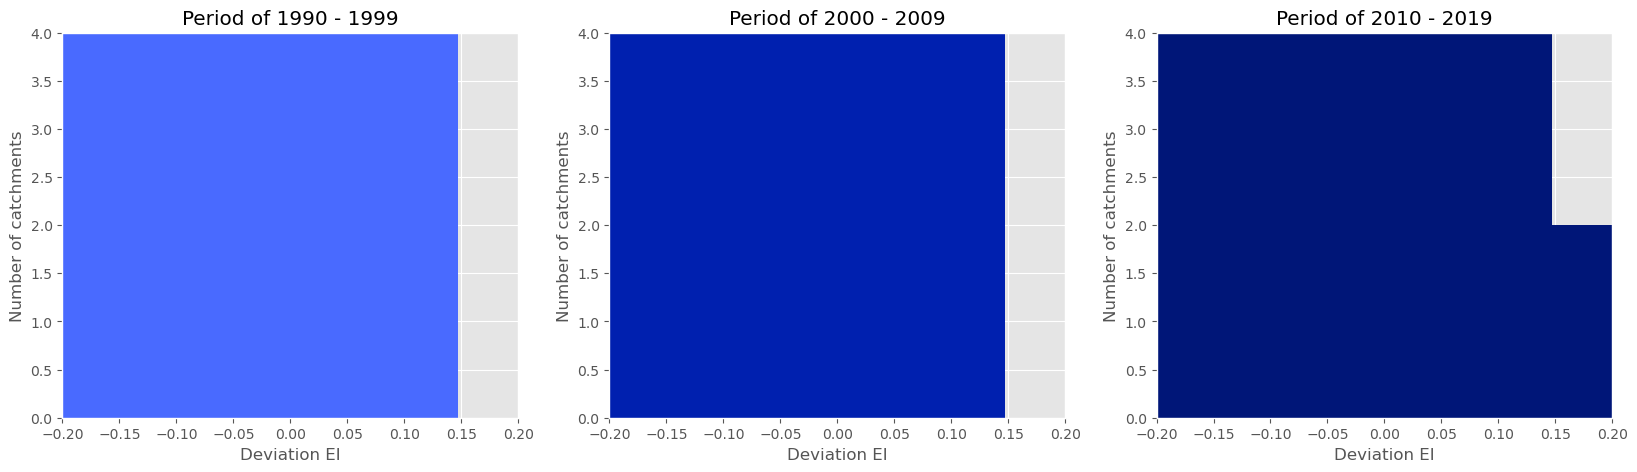

In [99]:
catchment_list = meuse_names_fr
df_output = df_output_fr
yrsl = yrsl_fr

n_tot = len(yrsl) - 1 
fig, axs = plt.subplots(1, n_tot)
fig.set_figheight(5)
fig.set_figwidth(20)

for j in range(len(yrsl)):
    if j > 0:
        yr = yrsl[j]
        c = colors[j]
        n = j - 1
        df_output.plot.hist(column=[f'EI deviation {yr}'], bins=500,color=c, ax=axs[n], ylim=(0,4), xlim=(-0.2,0.2))
        axs[n].set_xlabel("Deviation EI")
        axs[n].set_ylabel("Number of catchments")
        axs[n].set_title(f"Period of {yr}")
        axs[n].get_legend().remove()
    
plt.savefig(f'2_Output/{output}/Histograms/Histograms_EI_FR.png')   
# plt.close(fig)

### Histogram EI deviations per time slice (BE)

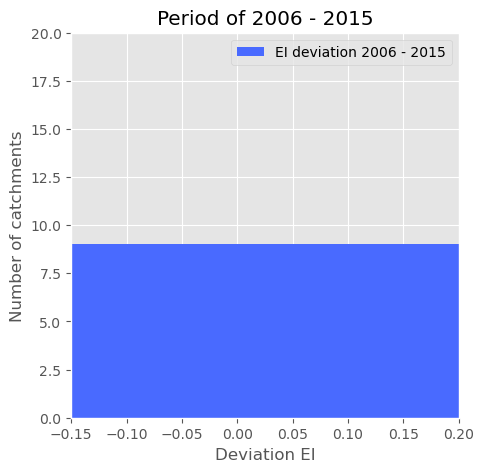

In [100]:
catchment_list = meuse_names_be2
df_output = df_output_be
yrsl = yrsl_be

n_tot = len(yrsl) - 1 
fig, axs = plt.subplots(1, n_tot)
fig.set_figheight(5)
fig.set_figwidth(5)

for j in range(len(yrsl)):
    if j > 0:
        yr = yrsl[j]
        c = colors[j]
        n = j - 1
        df_output.plot.hist(column=[f'EI deviation {yr}'], ax=axs, bins=100,color=c, ylim=(0,20), xlim=(-0.15,0.2))
        axs.set_xlabel("Deviation EI")
        axs.set_ylabel("Number of catchments")
        axs.set_title(f"Period of {yr}")
        # axs.get_legend().remove()
    
plt.savefig(f'2_Output/{output}/Histograms/Histograms_EI_BE.png')   
# plt.close(fig)

### Histogram EI deviations combined time periods (overlapping) (BE+FR)

<Figure size 700x500 with 0 Axes>

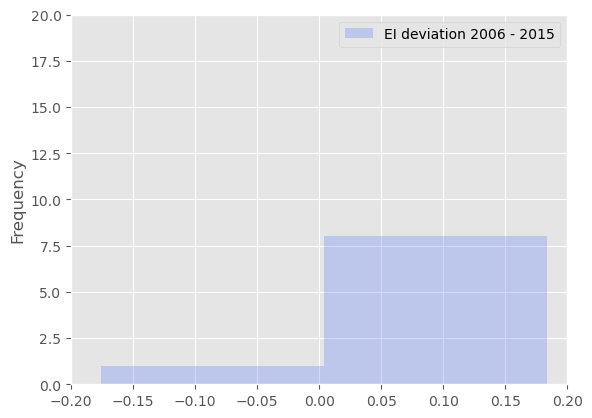

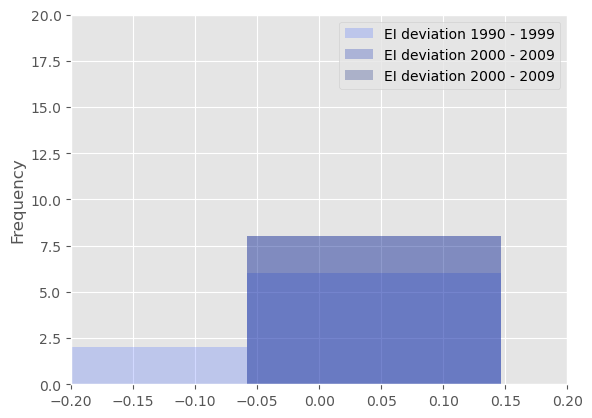

In [101]:
"Deze klopt nog niet want nog niet alles is samengevoegd"

catchment_list = meuse_names_be2
df_output = df_output_be
yrsl = yrsl_be

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(7)
              
df_output.plot.hist(column=[f'EI deviation {yrsl[1]}'], bins=2000, color=[colors[1], colors[2]], alpha=0.25, ylim=(0,20), xlim=(-0.2,0.2))

catchment_list = meuse_names_fr
df_output = df_output_fr
yrsl = yrsl_fr

df_output.plot.hist(column=[f'EI deviation {yrsl[1]}', f'EI deviation {yrsl[2]}', f'EI deviation {yrsl[2]}'], bins=2000, color=[colors[1], colors[2], colors[3]], alpha=0.25, ylim=(0,20), xlim=(-0.2,0.2))

plt.legend(loc='upper right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_time_combined_5.png')   
# plt.close(fig)

### Histogram EI deviations combined time periods (not overlapping)

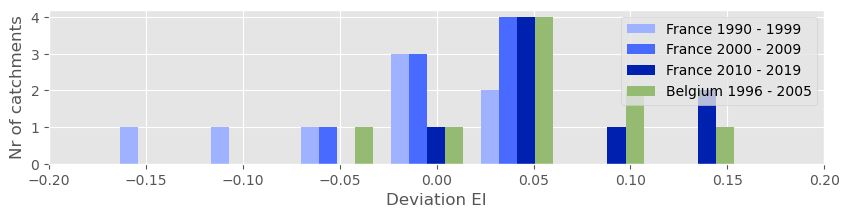

In [102]:
"Histogram EI deviations combined time periods (not overlapping)"

colors3 = [colors[0], colors[1], colors[2], "#95bb72"]
labels = [f'France {yrsl_fr[1]}', f'France {yrsl_fr[2]}', f'France {yrsl_fr[3]}', f'Belgium {yrsl_be[0]}']

fig = plt.figure()
fig.set_figheight(2)
fig.set_figwidth(10)
EI_dev_grouped = [[], [], [], []]

df_output = df_output_fr
catchment_list = meuse_names_fr
        
for j in range(len(yrsl_fr)):  
    EI_dev_total = []
    if j > 0:
        for i in range(len(catchment_list)):
            EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl_fr[j]}']].item()
            EI_dev_grouped[j-1].append(EI_dev)
                
df_output = df_output_be
catchment_list = meuse_names_be2 
                
for j in range(len(yrsl_be)):  
    EI_dev_total = []
    if j > 0:
        for i in range(len(catchment_list)):
            EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl_be[j]}']].item()
            EI_dev_grouped[3].append(EI_dev)
            
plt.hist(EI_dev_grouped, bins=7, alpha = 1, color = colors3, label=labels)
plt.xlim(-0.2, 0.2)
plt.xlabel('Deviation EI')
plt.ylabel('Nr of catchments')
plt.legend(loc='upper right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_time_combined_notoverlapping_4.png')   

### Histogram EI deviations grouped by aridity (not overlapping) (FR+BE)

2
2
4
4
4
1


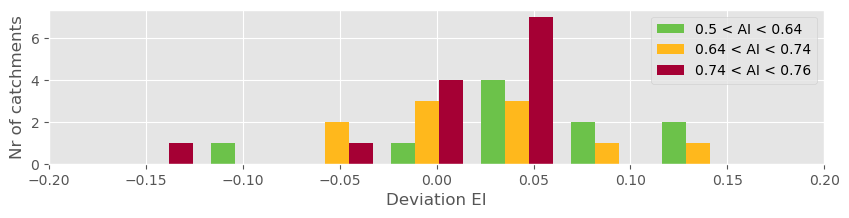

In [110]:
aridities = ["Wet", "Medium", "Arid"]
AI_names = [f"{min_AI:.2} < AI < {cut1_AI:.2}", f"{cut1_AI:.2} < AI < {cut2_AI:.2}", f"{cut2_AI:.2} < AI < {max_AI:.2}"]


fig = plt.figure()
fig.set_figheight(2)
fig.set_figwidth(10)
EI_dev_grouped = [[], [], []]

for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
    
        catchment_list_wet = catchment_list_fr_wet
        catchment_list_med = catchment_list_fr_med
        catchment_list_arid = catchment_list_fr_arid
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        
        catchment_list_wet = catchment_list_be_wet
        catchment_list_med = catchment_list_be_med
        catchment_list_arid = catchment_list_be_arid        
        
    
    for a in range(len(aridities)):
        EI_dev_total = []
        if a == 0:
            catchment_list = catchment_list_wet
        elif a == 1:
            catchment_list = catchment_list_med
        elif a == 2:
            catchment_list = catchment_list_arid
    
        for j in range(len(yrsl)):  
            if j > 0:
                for i in range(len(catchment_list)):
                    EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                    EI_dev_grouped[a].append(EI_dev)
            
plt.hist(EI_dev_grouped, bins=7, alpha = 1, color = colors2, label=AI_names)
plt.xlim(-0.2, 0.2)

plt.xlabel('Deviation EI')
plt.ylabel('Nr of catchments')

print(len(catchment_list_fr_wet))
print(len(catchment_list_fr_med))
print(len(catchment_list_fr_arid))

print(len(catchment_list_be_wet))
print(len(catchment_list_be_med))
print(len(catchment_list_be_arid))

plt.legend(loc='upper right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_time_combined_notoverlapping_4.png')   

### Histogram EI deviations grouped by seasonality index (not overlapping) (FR+BE)

4
2
3
2
4
2
17


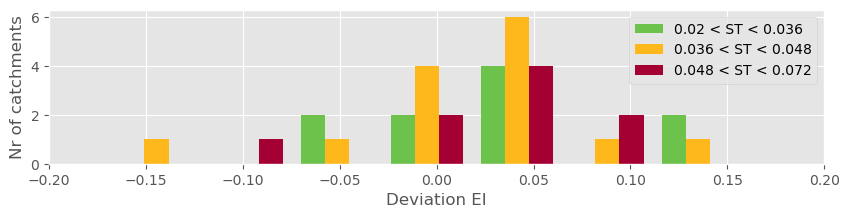

In [104]:
ST_names = [f"{min_ST:.1} < ST < {cut1_ST:.2}", f"{cut1_ST:.2} < ST < {cut2_ST:.2}", f"{cut2_ST:.2} < ST < {max_ST:.2}"]

fig = plt.figure()
fig.set_figheight(2)
fig.set_figwidth(10)
EI_dev_grouped = [[], [], []]

for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
    
        catchment_list_STlow = catchment_list_fr_STlow
        catchment_list_STmed = catchment_list_fr_STmed
        catchment_list_SThigh = catchment_list_fr_SThigh
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        
        catchment_list_STlow = catchment_list_be_STlow
        catchment_list_STmed = catchment_list_be_STmed
        catchment_list_SThigh = catchment_list_be_SThigh        
        
    
    for a in range(len(ST_names)):
        EI_dev_total = []
        if a == 0:
            catchment_list = catchment_list_STlow
        elif a == 1:
            catchment_list = catchment_list_STmed
        elif a == 2:
            catchment_list = catchment_list_SThigh
    
        for j in range(len(yrsl)):  
            if j > 0:
                for i in range(len(catchment_list)):
                    EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                    EI_dev_grouped[a].append(EI_dev)
             
plt.hist(EI_dev_grouped, bins=7, alpha = 1, color = colors2, label=ST_names)
plt.xlim(-0.2, 0.2)

plt.xlabel('Deviation EI')
plt.ylabel('Nr of catchments')


plt.legend(loc='upper right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_time_combined_notoverlapping_Seasonality_4.png')   

print(len(catchment_list_be_STlow))
print(len(catchment_list_be_STmed))
print(len(catchment_list_be_SThigh))

print(len(catchment_list_fr_STlow))
print(len(catchment_list_fr_STmed))
print(len(catchment_list_fr_SThigh))

print(len(meuse_names_be2)+len(meuse_names_fr))

### Plot correlations

In [105]:
print(meuse_names_be)

for k in range(len(descriptors)):
    fig, axs = plt.subplots(1, 1)
    fig.set_figheight(5)
    fig.set_figwidth(7)
    
    EI_dev_total = []
    des_change_total = []
    
    catchment_list = meuse_names_fr
    df_output = df_output_fr
    yrsl = yrsl_fr
    
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                des_change = df_output.loc[catchment_list[i],[f'{descriptors[k]}_change {yrsl[j]}']].item()
                des_change_total.append(des_change)
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                plt.plot(df_output[f'{descriptors[k]}_change {yrsl[j]}'], df_output[f'EI deviation {yrsl[j]}'], '.', c=colors[j])
                
    catchment_list = meuse_names_be2
    df_output = df_output_be
    yrsl = yrsl_be
    
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                des_change = df_output.loc[catchment_list[i],[f'{descriptors[k]}_change {yrsl[j]}']].item()
                des_change_total.append(des_change)
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                plt.plot(df_output[f'{descriptors[k]}_change {yrsl[j]}'], df_output[f'EI deviation {yrsl[j]}'], '.', c='#95bb72')                 

    x = des_change_total
    y = EI_dev_total
    
    pearson = pearsonr(x, y)
    m, b = np.polyfit(x, y, 1)
    pearsony = np.zeros(len(x))
    
    for q in range(len(EI_dev_total)):
        pearsony[q] = m * x[q] + b
    axs.plot(x, pearsony, 'k')
                
        
    axs.set_xlabel(f"Change in {descriptors_names[k]}")
    axs.set_ylabel(f"Devation Evaporative Index")
    axs.set_title(f"Meuse {descriptors_names[k]}")
    
    
    legend = [
            Line2D([0], [0], marker='.', color='gainsboro', label=f'France {yrsl_fr[1]}',
                       markerfacecolor=f'{colors[1]}', markersize=15),
            Line2D([0], [0], marker='.', color='gainsboro', label=f'France {yrsl_fr[2]}',
                       markerfacecolor=f'{colors[2]}', markersize=15),
            Line2D([0], [0], marker='.', color='gainsboro', label=f'France {yrsl_fr[3]}',
                       markerfacecolor=f'{colors[3]}', markersize=15),
            Line2D([0], [0], marker='.', color='gainsboro', label=f'Belgium {yrsl_be[1]}',
                       markerfacecolor='#95bb72', markersize=15),
            Line2D([0], [0], color='k', label=f"Correlation of {pearson[0]:.2} with p-value of {pearson[1]:.4}" ,
                       markerfacecolor='k', markersize=10)]                    

    axs.legend(handles=legend,loc='lower right')
                
    plt.savefig(f'2_Output/{output}/Results/Change_total_time_{descriptors_names[k]}.png')   
    plt.close()

0            Membre Pont 
1            Sainte-Marie
2              Straimont 
3               Treignes 
4                  Chooz 
5             Daverdisse 
6                Jemelle 
7                Gendron 
8                Hastiere
9                  Yvoir 
10               Warnant 
11                Modave 
12                 Ortho 
13              Mabompre 
14               Tabreux 
15              Wiheries 
16             Salzinnes 
17             Huccorgne 
18                  Amay 
19            Martinrive 
20    Chaudfontaine Pisc 
Name: Read, dtype: object


## Plot EI expected

### BE - EI expected

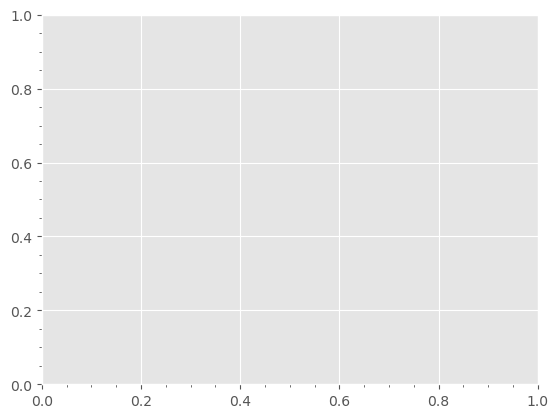

In [106]:
df_output = df_output_be
yrsl = yrsl_be
catchment_list = meuse_names_be2
yrcut = yrcut_be


for i in range(len(catchment_list)):
    # Import data and select right dates
    data = pd.read_csv("1_Data/final_names/"+str(catchment_list[i].strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    name = catchment_list[i].strip()
    nameupper = name.upper()
       
    # Read Belgian data        
    dataq = pd.read_csv("1_Data/SPW_names/"+str("SPW_Q_")+str(nameupper)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    dataq.columns = ['dt', 'Q']
    dataq.loc[:,'dt'] = pd.to_datetime(dataq['dt'])
    dataq.index = dataq['dt']
    
    # if name == "Salzinnes":
    #     name = "Salzinnes Ronet"
        
    are = df_area[df_area['Station']== name]
    area = are['area_m2'].item()

    dataq["hour"] = dataq["Q"] * 3600
    dataq_day = dataq.resample('D').sum() 
    dataq_day["day"] = dataq_day["hour"]
    dataq_day["Q_mm"] = dataq_day["day"] * 10**3   
    dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area

    
    # get the right dates (1996 - 2016)
    data = data.loc["1996-01-01":"2016-12-31"]
    data['dis_subcatch'] = dataq_day.loc["1996-01-01":"2016-12-31","Q_mm_area"]
            
    # Calculate mean values
    Ep = data['epot_subcatch'].mean() 
    P = data['prec_subcatch'].mean() 
    Q = data['dis_subcatch'].mean()
    
    #Compute actual evaporation, Evaporative Index and Aridity index
    Ea = P - Q 
    EI = Ea / P
    AI = Ep / P
    
    if AI < EI or Ea <0:
        print(f'Exclude catchment with ID {catchment_list[i]}')            
    
    # budyko plot
    budyko_curve_x = np.arange(1, 3, 0.05)
    energy_limit_x = np.arange(0, 1.0001, 0.05)
    x = np.arange(0, 1.0001, 0.05)
    water_limit_y = 1 + budyko_curve_x*0
    energy_limit_y = energy_limit_x
    y = 1 + x*0
    plt.minorticks_on()
        
    fig, axs = plt.subplots(2, 1)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.suptitle(f'catchment_with_ID{catchment_list[i]}')
        
    axs[0].plot(energy_limit_x, energy_limit_y, c='k')
    axs[0].plot(budyko_curve_x, water_limit_y,c='k')
    axs[0].set_ylabel("Actual ET/P")
    axs[0].set_xlabel("Potential ET/P")
    axs[0].minorticks_on()
        
    # plot annual deficits
    axs[1].set_ylabel(f'Root zone storage deficit [mm]')
    data['year'] = pd.DatetimeIndex(data['dt']).year  
    
    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
        AI = df_output.loc[catchment_list[i],[f'AI {yrsl[j]}']].item()
        EI = df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']].item()
        w = df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']].item()
        c = colors[j]
        yearslice = yrsl[j]
        
        # Compute the Makkink potential evaporation
        Ep = datanew['epot_subcatch'].mean()    
        T = datanew['temp_subcatch'].mean()
        P  = datanew['prec_subcatch'].mean()
        Q  = datanew['dis_subcatch'].mean()

        # Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  
        AI = Ep / P   
        EI = Ea / P 
                            
        # plot w function
        AI_array = np.arange(0, 3, 0.05)
        EI_out = w_function(AI_array, w)
        axs[0].plot(AI_array, EI_out, color=c, linewidth = 0.5)
        axs[0].plot(AI, EI, marker='.', color=c, markersize=10)

        
            
        # Calculate root zone storage deficits
        RP    = 20 #Return-period of 20 years
        P_ts  = datanew['prec_subcatch']
        EP_ts = datanew['epot_subcatch']

        Et = np.zeros(len(P_ts))
        SD = np.zeros(len(P_ts))

        for z in range(len(P_ts)):
            Et[z] = (EP_ts[z]/Ep) * Ea
            if z == 0:
                SD[z] = min(0, P_ts[z] - Et[z])
            else:
                SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
        datanew.loc[:,'SD'] = SD

        axs[1].plot(datanew['SD'], linewidth = 0.5, c=c)
        
    legend_0 = [Line2D([0], [0], marker='d', color='lightgrey', label='Expected value EI',
                       markerfacecolor='k', markersize=10),
                Line2D([0], [0], marker='.', color='lightgrey', label='Actual value EI',
                       markerfacecolor='k', markersize=15)]
    
    legend_1 = [Line2D([0], [0], color=colors[0], lw=1, label=f'{yrsl[0]}'),
                Line2D([0], [0], color=colors[1], lw=1, label=f'{yrsl[1]}')]

    axs[0].legend(handles=legend_0,loc='lower right')
    axs[1].legend(handles=legend_1,loc='lower right')
    plt.savefig(f'2_Output/{output}/Catchments2/BE/Expected_Budyko_and_deficits_nr_of_catchment_with_ID{catchment_list[i]}.png')   
    plt.close(fig)

### FR - EI expected

In [107]:
catchment_list = meuse_names_fr
warnings.filterwarnings('ignore')
df_output = pd.DataFrame(index=catchment_list)

yrsl = yrsl_fr

for i in range(len(catchment_list)):
    name = fr_dict_code[st[i]]
    df_station = df_fr_new[df_fr_new["Code du site hydrométrique"] == st[i]]
    df_station.loc[:,'dt'] = pd.to_datetime(df_station["Date d'observation élaborée hydrométrique"])
    df_station.index = df_station['dt']
    df_station["Q"] = df_station["Résultat de l'observation élaborée hydrométrique"].astype('float32') / 1000 #  l/s naar m3/s
    dataq_fr = df_station[['Code de la station hydrométrique', 'dt', 'Q']].copy()
    dataq_fr = dataq_fr.dropna(axis='rows')
    
    data = pd.read_csv("1_Data/final_names/"+str(name.strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    namefr = fr_dict_inv[name]  
    are = df_area[df_area['Station']== namefr]
    area = are['area_m2'].item()
    
    dataq_fr["hour"] = dataq_fr["Q"] * 3600 * 24
    dataq_fr_day = dataq_fr.resample('D').sum() 
    dataq_fr_day["day"] = dataq_fr_day["hour"]
    dataq_fr_day["Q_mm"] = dataq_fr_day["day"]   * 10**3
    dataq_fr_day["Q_mm_area"] = dataq_fr_day["Q_mm"] / area
    
#    Get the right dates (1996 - 2016)
    data = data.loc["1980-01-01":"2016-12-31"]
    data['dis_subcatch'] = dataq_fr_day.loc["1980-01-01":"2016-12-31","Q_mm_area"]
    # display(data)

       
#     # Calculate mean values
    Ep = data['epot_subcatch'].mean() 
    P = data['prec_subcatch'].mean() 
    Q = data['dis_subcatch'].mean()
    T = data['temp_subcatch'].mean()
    
#     #Compute actual evaporation, Evaporative Index and Aridity index
    Ea = P - Q 
    EI = Ea / P
    AI = Ep / P
    
    print(catchment_list[i], EI, AI)
    if AI < EI or Ea < 0:
        print(f'Exclude catchment with ID {catchment_list[i]}')
    
    budyko_curve_x = np.arange(1, 3, 0.05)
    energy_limit_x = np.arange(0, 1.0001, 0.05)
    x = np.arange(0, 1.0001, 0.05)
    water_limit_y = 1 + budyko_curve_x*0
    energy_limit_y = energy_limit_x
    y = 1 + x*0
        
    fig, axs = plt.subplots(2, 1)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.suptitle(f'FR {name}', fontsize = 20)

    axs[0].plot(energy_limit_x, energy_limit_y, c='k')
    axs[0].plot(budyko_curve_x, water_limit_y,c='k')

    axs[0].set_ylabel("Actual ET/P")
    axs[0].set_xlabel("Potential ET/P")
    axs[0].minorticks_on()
                             
    # plot annual deficits
    axs[1].set_ylabel(f'Root zone storage deficit [mm]')
    
    # Seperate data into slices
    data['year'] = pd.DatetimeIndex(data['dt']).year
    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
        c = colors[j]
        yearslice = yrsl[j]    
                    
        #Compute the Makkink potential evaporation
        Ep = datanew['epot_subcatch'].mean()    
        T = datanew['temp_subcatch'].mean()
        P  = datanew['prec_subcatch'].mean()
        Q  = datanew['dis_subcatch'].mean()

        #Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  # actual evaporation
        AI = Ep / P   # aridity index
        EI = Ea / P # evaporative index
        
        if AI < EI:
            print(f'Exclude catchment with ID (2) {catchment_list[i]}')
                    
        EI_line = np.linspace(EI, EI, 1000000)
        w_array = np.linspace(0, 5000, 1000000)
        Eq_tosolve = 1 + AI - (1 + (AI**w_array))**(1/w_array)

        first_line = LineString(np.column_stack((w_array, EI_line)))
        second_line = LineString(np.column_stack((w_array, Eq_tosolve)))
        intersection = first_line.intersection(second_line)

        w = intersection.x

        # plot w function
        AI_array = np.arange(0, 3, 0.05)
        EI_out = w_function(AI_array, w)
        axs[0].plot(AI_array, EI_out,color=c)
        axs[0].plot(AI, EI, marker='o', color=c, label=f'omega = {w:.5f}',markersize =5)
            
        # Calculate root zone storage deficits
        RP    = 20 #Return-period of 20 years
        P_ts  = datanew['prec_subcatch']
        EP_ts = datanew['epot_subcatch']

        Et = np.zeros(len(P_ts))
        SD = np.zeros(len(P_ts))

        for z in range(len(P_ts)):
            Et[z] = (EP_ts[z]/Ep) * Ea
            if z == 0:
                SD[z] = min(0, P_ts[z] - Et[z])
            else:
                SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
        datanew.loc[:,'SD'] = SD

        axs[1].plot(datanew['SD'], linewidth = 0.5, c=c)

        # Save to Output 
        df_output.loc[catchment_list[i],[f'AI {yrsl[j]}']] = AI
        df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']] = EI
        df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']] = w                    
    
        
        axs[0].legend(loc='lower right')
        plt.savefig(f'2_Output/{output}/Catchments/FR/Budyko_and_deficits_of_catchment_{name}.png')  
        
    plt.close(fig)
    
print("end loop")

df_output_fr = df_output

IndexError: invalid index to scalar variable.

# Budyko

In [ ]:
plt.figure(figsize=(10,5)).suptitle("Meuse data (n=31)",fontsize=20)
plt.ylabel("Actual ET/P")
plt.xlabel("Potential ET/P")
n = 0

budyko_curve_x = np.arange(1, 3, 0.05)
energy_limit_x = np.arange(0, 1.0001, 0.05)
x = np.arange(0, 1.0001, 0.05)

water_limit_y = 1 + budyko_curve_x*0
energy_limit_y = energy_limit_x
y = 1 + x*0

plt.plot(energy_limit_x, energy_limit_y, c='k')
plt.plot(budyko_curve_x, water_limit_y,c='k')

# Load france data

for code in st:
    name = fr_dict_code[code]
    df_station = df_fr_new[df_fr_new["Code du site hydrométrique"] == code]
    df_station.loc[:,'dt'] = pd.to_datetime(df_station["Date d'observation élaborée hydrométrique"])
    df_station.index = df_station['dt']
    df_station["Q"] = df_station["Résultat de l'observation élaborée hydrométrique"].astype('float32') / 1000 #  l/s naar m3/s
    dataq_fr = df_station[['Code de la station hydrométrique', 'dt', 'Q']].copy()
    dataq_fr = dataq_fr.dropna(axis='rows')
    
    data = pd.read_csv("1_Data/final_names/"+str(name.strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    namefr = fr_dict_inv[name]  
    are = df_area[df_area['Station']== namefr]
    area = are['area_m2'].item()
    
    dataq_fr["hour"] = dataq_fr["Q"] * 3600 * 24
    dataq_fr_day = dataq_fr.resample('D').sum() 
    dataq_fr_day["day"] = dataq_fr_day["hour"]
    dataq_fr_day["Q_mm"] = dataq_fr_day["day"]   * 10**3
    dataq_fr_day["Q_mm_area"] = dataq_fr_day["Q_mm"]/ area
    
#    Get the right dates (1996 - 2016)
    data = data.loc["1980-01-01":"2016-12-31"]
    data['dis_subcatch'] = dataq_fr_day.loc["1980-01-01":"2016-12-31","Q_mm_area"]    
    
    # plot budyko
    # Calculate mean values
    Ep = data['epot_subcatch'].mean() 
    P = data['prec_subcatch'].mean() 
    Q = data['dis_subcatch'].mean()
        
    #Compute actual evaporation and Evaporative Index and Aridity index
    Ea = P - Q  # actual evaporation
    AI = Ep / P   # aridity index
    EI = Ea / P # evaporative index
        
    if Ea > 0 and AI > EI: # exclude negative values and catchments with AI < EI (energy constraint)
        # plot budyko
        plt.plot(AI, EI, marker='.', c = 'b')
        n+=1
        
print(f'n with only france data is {n}')

df_omega = pd.DataFrame(index=meuse_names_be)
colors = ['#9FB2FF', '#496AFF', '#0020AF']
yrs = ['1996-2005', '2006-2015']

# Load belgian data

for i in range(len(meuse_names_be)):
    data = pd.read_csv("1_Data/final_names/"+str(meuse_names_be[i].strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    name = meuse_names_be[i].strip()
    nameupper = name.upper()
            
    # Read Belgian data        
    dataq = pd.read_csv("1_Data/SPW_names/"+str("SPW_Q_")+str(nameupper)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    dataq.columns = ['dt', 'Q']
    dataq.loc[:,'dt'] = pd.to_datetime(dataq['dt'])
    dataq.index = dataq['dt']
    
    if name == "Salzinnes":
        name = "Salzinnes Ronet"
        
    are = df_area[df_area['Station']== name]
    area = are['area_m2'].item()

    dataq["hour"] = dataq["Q"] * 3600
    dataq_day = dataq.resample('D').sum() 
    dataq_day["day"] = dataq_day["hour"]
    dataq_day["Q_mm"] = dataq_day["day"] * 10**3   
    dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
    
    # get the right dates (1996 - 2016)
    data = data.loc["1996-01-01":"2016-12-31"]
    data['dis_subcatch'] = dataq_day.loc["1996-01-01":"2016-12-31","Q_mm_area"]
            
    # Calculate mean values
    Ep = data['epot_subcatch'].mean() 
    P = data['prec_subcatch'].mean() 
    Q = data['dis_subcatch'].mean()
    
    #Compute actual evaporation, Evaporative Index and Aridity index
    Ea = P - Q 
    EI = Ea / P
    AI = Ep / P
    
    
    if Ea > 0 and AI > EI: 
        plt.ylabel("Actual ET/P")
        plt.xlabel("Potential ET/P")
        plt.plot(AI, EI, marker=".", c = '#95bb72')
        n+=1
        
# plt.legend(['Belgium', 'France'])

red_patch = Patch(color='#95bb72', label='Belgium')
blue_patch = Patch(color='blue', label='France')
plt.legend(handles=[red_patch, blue_patch])

print(f'n with france and beglian data data is {n}')
plt.savefig(f'2_Output/{output}/Budyko7.png')   